# Coursework 2 - Neural Networks and Unsupervised Learning

__Name__: Georgios Alevras <br> __CID__: 01531221 <br> __Date__: 25/03/2022

<a name="outline"></a>

## Outline

- [Preliminaries](#preliminaries): Exploratory Data Analysis
- [Task 1](#task-1): Neural Networks
  - [1.1](#q11) Multi-Layer Perceptron (MLP)
  - [1.2](#q12) Convolutional Neural Network (CNN)
- [Task 2](#task-2): Unsupervised Learning
  - [2.1](#q21) Dimensionality Reduction and Clustering of a Subset of the Fashion-MNIST Image Data
  - [2.2](#q22) Clustering of the Feature Matrix
  - [2.3](#q23) Graph-Based Analysis
- [Task 3](#task-3): Mastery Component
  - [3.1](#q31) Non-Negative Matrix Factorization (NMF) for Dimensionality Reduction
  - [3.2](#q32) Community Detection

<a name="preliminaries"></a>
# Preliminaries: Exploratory Data Analysis [^](#outline)

Firstly, we import all the necessary Python packages to perform and execute all calculations and computations.

In [1]:
# All packages used in this coursework are imported here.
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf  # Warning sign appears because I use Ubuntu and I haven't installed NVIDIA drivers so my GPU is not used.
import os
from IPython.display import Image

2022-03-24 14:11:13.843942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-24 14:11:13.843974: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We then import the dataset (both train and test data) using the function provided below, and perform an initial inspection of it, printing the shapes of each (x_train, y_train, x_test, y_test).

In [2]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)  # convert labels to categorical samples
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return (x_train, y_train, x_test, y_test)

In [3]:
x_train, y_train, x_test, y_test = load_data()  # import the data
print('Shape of x_train:', x_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of x_test:', x_test.shape)
print('Shape of y_test:', y_test.shape)

Shape of x_train: (60000, 28, 28)
Shape of y_train: (60000, 10)
Shape of x_test: (10000, 28, 28)
Shape of y_test: (10000, 10)


We see that the training data consists of $60,000$ images of dimensions (pixels) $28$ by $28$ as our input data, and $60,000$ output vectors of size $10$, denoting the class category (what garment is depicted by each image, e.g., $0$ for T-shirt, $6$ for pullover, $3$ for dress, etc.). Similarly, the test data consists of $10,000$ images of the same dimensions as in the train data, and $10,000$ output vectors of size $10$, again, denoting the class category. To further inspect how they look, we depict a few examples below in *Figure 1*.

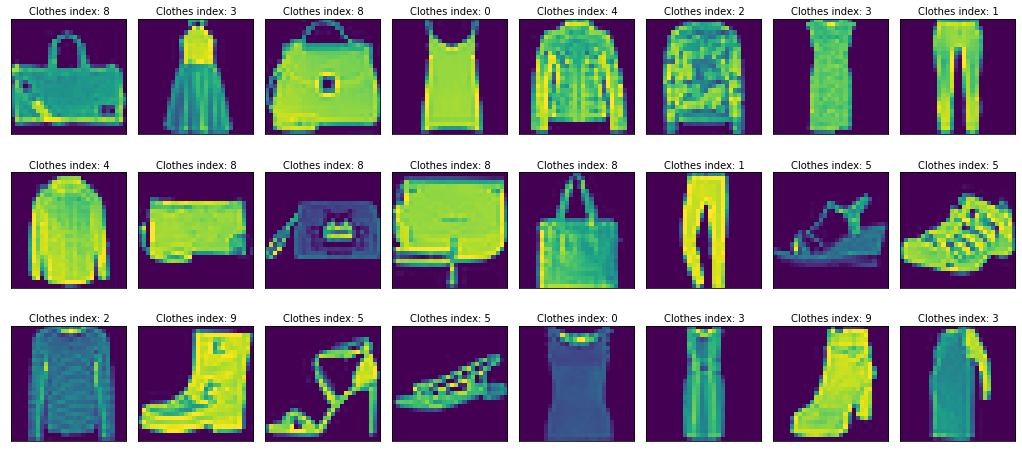

In [4]:
n_rows, n_cols = 3, 8
random_inx = np.random.choice(x_train.shape[0], n_rows * n_cols, replace=False)  # Selecting random data points from train data
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 8))
fig.subplots_adjust(hspace=0.2, wspace=0.1)

for n, i in enumerate(random_inx):
    row = n // n_cols
    col = n % n_cols
    axes[row, col].imshow(x_train[i])  # Visualising image
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
    axes[row, col].text(4., -1.5, f'Clothes index: {np.argmax(y_train[i])}')  # Categorising output by index of output vector
plt.show()

**Figure 1:** A set of $24$ randomly selected images from the train dataset with their class category written above each image, denoted by the index of the output (category) vector it belongs to.

Finally, we can explore the class distribution of the data by obtaining the number of pictures that belong to each class, as shown below.

In [5]:
number_of_images_per_class_train = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}  # dictionary to hold occurence of each class (clothes type)
for i in range(len(y_train)):
    number_of_images_per_class_train[np.argmax(y_train[i])] += 1

number_of_images_per_class_test = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0}  # dictionary to hold occurence of each class (clothes type)
for i in range(len(y_test)):
    number_of_images_per_class_test[np.argmax(y_test[i])] += 1

for i in range(len(number_of_images_per_class_train.keys())-1):  # loops through all classes to check they are all equivalent
    assert(number_of_images_per_class_train[i] == number_of_images_per_class_train[i+1])  # ensuring occurences of all classes are equivalent
    assert(number_of_images_per_class_test[i] == number_of_images_per_class_test[i+1])  # ensuring occurences of all classes are equivalent

print('Number of each category of clothes (train):', number_of_images_per_class_train)
print('Number of each category of clothes (test):', number_of_images_per_class_test)

Number of each category of clothes (train): {0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
Number of each category of clothes (test): {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


We can see that the two datasets are well-balanced with an equal number of items belonging to each class both for our train and our test data, as was also verified from all assertions returning True. As a result of the dataset being well-balanced, **we expect a baseline accuracy of 10%** (1 over the number of classes), thus, if the MLP obtains an accuracy less than 10% the model would perform worse than picking at random, while any accuracy above 10% demonstrates that the MLP has at least some predictive power. Next, we build our MLP.

<a name="task-1"></a>
# Task 1: Neural Networks [^](#outline)

<a name="q11"></a>

## 1.1 Multi-Layer Perceptron (MLP) [^](#outline)

<a name="q110a"></a>

#### 1.1.0.a Structure of MLP [^](#outline)

The Multi-Layer Perceptron (MLP) is a specific kind of feed-forward Artificial Neural Network (ANN) which consists of an input layer, an output layer and some number $L \in \mathbb{Z}^+$ of hidden layers, all of which are dense / fully-connected (all nodes in one layer are connected to all other nodes in the next layer). The MLP consists of the composition of many affine transformations, followed by the application of non-linear activation functions which operate element-wise. The architecture of the network can be fully described by the following equations:
$$\mathbf{h}^{(0)}:=\mathbf{x},$$
$$\mathbf{h}^{(k)}=\sigma \left( \mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)} \right), \quad k=1, \dots, L,$$
$$\mathbf{\hat{y}} = \sigma_\text{out}\left( \mathbf{w}^{(L)} + \mathbf{b}^{(L)} \right),$$

where $\mathbf{x} \in \mathbb{R}^D$ is an example input, $\mathbf{W}^{(k)} \in \mathbb{R}^{n_{k+1} \times n_k}$ is the matrix holding the weights between nodes of layer $n_k$ and $n_{k+1}$, $\mathbf{b}^{(k)} \in \mathbb{R}^{n_{k+1}}$ is the vector of biases added to the pre-activations $\mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)}$ at layer $k$, $\mathbf{h}^{(k)} \in \mathbb{R}^{n_{k}}$ is the vector of post-activation (or activation) values at layer $k$, $n_0 := D$, and $n_k$ is the number of nodes (neurons) at the $k$-th hidden layer. The activation function applied to the pre-activation values is $\sigma:\mathbb{R} \rightarrow \mathbb{R}$, while the activation function applied to the output values is $\sigma_\text{out}:\mathbb{R} \rightarrow \mathbb{R}$.

<a name="q110b"></a>

#### 1.1.0.b Error Backpropagation [^](#outline)

Using the set of equations described above we can perform a forward pass on a data-point (or a set of data-points) to predict its (or their) output(s). However, initially, all the weights and biases are random - the MLP has not learned anything. Therefore, we want to learn the model to make good predictions. We achieve this via ***error backpropagation*** through:
1. the computation of the *stochastic gradient of the loss function* with respect to the parameters (weights and biases) of the MLP,
2. the update of the MLP parameters using the already-computed gradients

Once we have computed all gradients for all model parameters we can update them according to *stochastic gradient descent* as such:

$$\theta_{t+1}=\theta_t - \eta\nabla_t L(\theta_t;D_m), \quad t \in \mathbb{N}_0,$$

for each iteration $t$, where $\eta$ is the *learning rate* and the loss value $L$ is evaluated using a randomly sampled subset of the training data $\mathcal{D}_m$ called a ***batch***, where $|\mathcal{D}_m| \ll |\mathcal{D}_\text{train}|$. The loss value $L$ is the average loss value from all data-points in a batch $\mathcal{D}_m$:

$$L(\theta_t; \mathcal{D}_m)=\frac{1}{M}\sum_{x_i, y_i \in \mathcal{D}_m} l(y_i, f_{\theta_t}(x_i)),$$

where $f_{\theta_t}(x_i)$ is the MLP model, and $L_i := l(y_i, f_{\theta_t}(x_i))$ is the per-example (data-point) loss. Therefore, our goal is to compute all gradients (using the chain rule):

$$\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}\frac{\partial{a_p^{(k+1)}}}{\partial{w_{pq}^{(k)}}},$$
$$\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}\frac{\partial{a_p^{(k+1)}}}{\partial{b_p^{(k)}}},$$

where $\mathbf{a}^{(k)}=\mathbf{W}^{(k-1)}\mathbf{h}^{(k-1)} + \mathbf{b}^{(k-1)}$ are the pre-activation values, which enable us to simplify the above equations as:

$$\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}}h_q^{(k)} =: \delta_p^{(k+1)}h_q^{(k)},$$
$$\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\frac{\partial{L_i}}{\partial{a_p^{(k+1)}}} =: \delta_p^{(k+1)},$$

where $\delta_p^{(k)} := \frac{\partial{L_i}}{\partial{a_p^{(k)}}}$. Next, we have to evaluate $\delta_p^{(k)}$:
$$\delta_p^{(k)}= \frac{\partial{L_i}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \frac{\partial{L_i}}{\partial{a_j^{(k+1)}}} \frac{\partial{a_j^{(k+1)}}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \delta_j^{(k+1)} \frac{\partial{a_j^{k+1}}}{\partial{a_p^{(k)}}}.$$

Knowing that: $a_j^{k+1}=\sum_{l=1}^{n_k} w_{jl}^{(k)}\sigma(a_l^{(k)}) + b_p^{(k)}$, we get: $\frac{\partial{a_j^{(k+1)}}}{\partial{a_p^{(k)}}}=w_{jp}^{(k)}\sigma'(a_p^{(k)})$, which means that:

$$\delta_p^k=\frac{\partial{L_i}}{\partial{a_p^{(k)}}} = \sum_{j=1}^{n_{k+1}} \delta_p^{(k+1)} \frac{\partial{a_j^{k+1}}}{\partial{a_p^{(k)}}}=\sigma'(a_p^{(k)}) \sum_{j=1}^{n_{k+1}} w_{jp}^{(k)}\delta_p^{(k+1)} = \sigma'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T \delta^{(k+1)},$$

where $\sigma'(\mathbf{a}^{(k)})=\text{diag}([\sigma'(a_p^{(k)})]_{p=1}^{n_k}).$ 

Therefore, in order for the MLP to learn, we need to:

1. Perform a forward pass on a batch of data-points through the MLP, computing and storing all pre-activations $\mathbf{a}^{(k)}$ and post-activations $\mathbf{h}^{(k)}$
2. Evaluate the errors on the output layer, $\delta^{(L+1)}=\frac{\partial{L_i}}{\partial{\mathbf{a}^{L+1}}}$
3. Backpropagate the errors for each layer using $\delta^{(k)}=\sigma'(\mathbf{a}^{(k)})(\mathbf{W}^{(k)})^T \delta^{(k+1)}$
4. Use the errors to obtain the derivatives of the per-example loss values: $\frac{\partial{L_i}}{\partial{w_{pq}^{(k)}}}=\delta_p^{(k+1)}h_q^{(k)}$, $\frac{\partial{L_i}}{\partial{b_p^{(k)}}}=\delta_p^{(k+1)}$
5. Update the MLP parameters using stochastic gradient descent: $\theta_{t+1}=\theta_t - \eta\nabla_t L(\theta_t;D_m)$

<a name="q110c"></a>

#### 1.1.0.c Architecture of MLP for this Task [^](#outline)

For this particular task we need to choose the architecture of the model; the number of hidden layers $L$, the number of nodes (neurons) in each layer (including the input and the output layers), the activation function $\sigma$, and the output activation function $\sigma_\text{out}$. Given the nature of our dataset, printed above, we naturally define the input layer to have $784 = 28 \times 28$ neurons, i.e., we flatten the 2D array of pixels for an image to get a 1D array which we define as $\mathbf{h}^0:=\mathbf{x}$, and we define our output layer to have $10$ neurons, one for each class. We then decide to have $5$ hidden layers, each with $400$ neurons; the layout of the MLP is demonstrated below in *Figure 2*.

![title](./Images/mlp_model.jpg)

**Figure 2:** Illustration of the architecture of the MLP used for **Task 1.1**, including the parameters at each layer and their dimensions.

Finally, we use $\text{LeakyReLU}(x)$ as the activation function for all layers except the output layer, for which we use the softmax function:

$$\text{LeakyReLU}(x)=\begin{cases} x, \quad x>0\\ \alpha x, \:\:\:x<=0\end{cases},$$

where $\alpha$ is a constant (in this case $\alpha=0.01$), and

$$\hat{\mathbf{y}}_j:=\text{softmax}(\mathbf{a}^{(L+1)})_j=\frac{\text{exp}(a_j)}{\sum_i \text{exp}(a_i)},$$

where $\mathbf{a}^{(L+1)}$ are the pre-activation values at the output layer, and $\hat{\mathbf{y}}$ is the vector of predicted probabilities for each class for a data-point.

Finally, the loss value for this MLP is obtained using the categorical cross-entropy loss function $L_\text{CE}$, which is given by:

$$L_\text{CE}=-\sum_{c=1}^C y_c \log{\hat{y}_c}, \quad \text{for} \: C \in \mathbb{N}_0 +1 \: \text{classes},$$

where $y_c$ is the ground truth for class $c$ and $\hat{y}_c$ is the softmax probability for class $c$. In order to be able to perform back-propagation we must be able to use the derivative functions of the activation functions, which are:

$$\text{LeakyReLU'}(x)=\begin{cases} 1, \quad x>0\\ \alpha, \:\:\:\:x<=0\end{cases},\\$$
$$\text{softmax'}(\mathbf{a}^{(L+1)})_j=\begin{cases} y_j(1-y_j), \quad i=j\\ -y_j y_i, \quad\:\:\:\:\:\:\:i \neq j\end{cases}.$$

In order to execute steps 2 and 3 outlined above, we want to find $\delta^{(L+1)}$, however, the derivative of the softmax function gives $\frac{\partial{\:\text{softmax}(\mathbf{a}^{(L+1)})_j}}{\partial{\mathbf{a}^{L+1}}}$. We can use the chain rule to obtain $\delta^{(L+1)}$ as such:

$$\delta^{(L+1)}_j=\sum_i \frac{\partial{L_\text{CE}}}{\partial{\:\text{softmax}(\mathbf{a}^{(L+1)})_i}}\frac{\partial{\:\text{softmax}(\mathbf{a}^{(L+1)})_i}}{\partial{\mathbf{a}^{L+1}}_j}$$

This result can be simplified significantly, as shown below:

$$
\quad\quad\quad\quad\: \delta^{(L+1)}_j=\frac{\partial{L_\text{CE}}}{\partial{\mathbf{a}^{L+1}}_j}=-\sum_i y_i  \frac{\partial{\log{\hat{y}_i}}}{\partial{\mathbf{a}^{L+1}}_j} \\
\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\:\:\:=-\sum_i y_i \frac{1}{\hat{y}_i}\frac{\partial{\hat{y}_i}}{\partial{\mathbf{a}^{L+1}}_j}, \quad \text{where} \:\: \hat{y}_i=\frac{\text{exp}(a_i^{L+1})}{\sum_j \text{exp}(a_j^{L+1})} \\
\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\quad\:=-\sum_{i=j} y_i \frac{1}{\hat{y}_i} \hat{y}_i(1-\hat{y}_i) - \sum_{i\neq j} y_i \frac{1}{\hat{y}_i} (-\hat{y}_i\hat{y}_j) \\
\quad\quad\quad\quad\quad\quad\:= -y_j(1-\hat{y}_j) + \sum_{i\neq j} y_i \frac{\hat{y}_i \hat{y}_j}{\hat{y}_i} \\
\quad\quad\quad\quad\:\:\:\:=-y_j + y_j \hat{y}_j + \sum_{i \neq j} y_i \hat{y}_j \\
\quad\quad\quad\:=\hat{y}_j \left( \sum_i y_i \right) - y_j \\
=\hat{y}_j - y_j \\
$$

Therefore, $\delta^{(L+1)}=\hat{\mathbf{y}} - \mathbf{y}$. As a result, we don't need to write a softmax derivative function; the error at the output layer can be simply written as $\delta^{(L+1)}=\hat{\mathbf{y}} - \mathbf{y}$. The activation functions, their derivative functions and softmax are outlined below.

In [7]:
def leakyrelu(x, alpha=0.01):
    # Returns x if x>0 and alpha*x if x<=0
	return x*(x>alpha) + alpha*x*(x<=alpha)

def leakyrelu_prime(x, alpha=0.01):
    # Returns 1 if x>0 and alpha if x<0
    return np.ones(x.shape)*(x>0) + alpha*(x<0)

def softmax(y):
    e = np.exp(y)  # exponentiates all output vectors y for each value in a batch
    sums = np.sum(e, axis=1)  # sums of each output vector y for each value in a batch
    return e*1/sums[:, np.newaxis]  # Divides exponentiated output vector y with corresponding sum

def cross_entropy(y, y_hat, e=1e-7):
    # Categorical cross-entropy used as loss function
    values = -y*np.log(y_hat+e)  # Small error added to avoid infinity / NaN issues when evaluating logs at 0
    return np.sum(values, axis=1)

Next, we define a class to build the MLP. The biases are initialised as zeros, while the weights are initialised from a Gaussian distribution $\mathcal{N}\left(0, \frac{2}{(n_{k}+n_{k+1})}\right)$ with $0$ mean and variance $2/(n_{k}+n_{k+1})$, where $n_{k}$ and $n_{k+1}$ are the number of neurons at the $k$-th and $(k+1)$-th layers respectively, known as the ***Glorot Initialisation***.

In addition, a subtlety that needs to be mentioned is how the algorithms for the forward pass and error backpropagation have been tweaked in order to allow to pass batches of data at once. For the most part, the vectors and matrices are simply expanded with an additional dimension to include the values for each data-point. However, this only works when matrix multiplication is desirable. In the case of outer products, we want to ensure that there is no cross-multiplication between different data-points. Therefore, in the case of $\frac{\partial{L_i}}{\partial{w_{pq}^l}}=\delta_p^{l+1}h_q^l$, we add an aditional axis to each variable to perform the outer product over the correct dimensions, as such: 

```Python 
self.grad_weights[k] = np.matmul(self.d[k][:, :, np.newaxis], self.h[k][:, np.newaxis, :]).mean(axis=0)
``` 

and then take the average value over all data-points in the batch to update the parameters. As a result, we perform a forward pass and an error-backpropagation with batches of $256$ data-points, making a single parameter update by averaging the gradients obtained from the $256$ data-points. Next, we obtain a batch (iteration) loss and accuracy by averaging the loss and accuracy of the $256$ data-points. Finally, once we have gone through the entire dataset using $\lceil \frac{N}{M} \rceil$ batches (for $N$ data-points and $M$-sized batches) we perform a forward pass and an error back-propagation of the entire dataset using the model parameters obtained from the last batch, to obtain an accuracy and loss value for one epoch - defined as the time unit of having gone through the entire dataset.

The MLP is outlined below.

In [316]:
class MLP():
    def __init__(self, mlp_configuration):
        self.config = mlp_configuration  # Configuration of MLP (number of neurons in each layer)
        self.hidden_layers = len(mlp_configuration) - 2  # Number of hidden layers
        # Weights between successive layers, initialised using the Glorot Initialisation
        self.weights = [np.random.normal(size=(mlp_configuration[k+1], mlp_configuration[k])) * np.sqrt(2./(mlp_configuration[k]+mlp_configuration[k+1])) for k in range(len(mlp_configuration)-1)]
        # Biases added to each layer to perform pre-activation
        self.biases = [np.zeros((mlp_configuration[k+1])) for k in range(len(mlp_configuration)-1)]
        self.a = [None for _ in range(len(mlp_configuration)-1)]  # Pre-activations
        self.h = [None for _ in range(len(mlp_configuration))]  # (Post) Activations
        self.d = [None for _ in range(len(mlp_configuration)-1)]  # Deltas - errors at each node
        self.grad_weights = [None for _ in range(len(mlp_configuration)-1)]  # Weights gradients
        self.grad_biases = [None for _ in range(len(mlp_configuration)-1)]  # Biases gradients
        self.batch_losses = []  # Will hold the batch (iteration) losses
        self.batch_accuracies = []  # Will hold the batch (iteration) accuracies
        self.epoch_losses = []  # Will hold the epoch losses
        self.epoch_accuracies = []  # Will hold the epoch accuracies
        self.test_epoch_losses = []  # Will hold the epoch test losses
        self.test_epoch_accuracies = []  # Will hold the epoch test accuracies

        
    def __str__(self):
        weights_shapes = [self.weights[i].shape for i in range(len(self.weights))]  # Shape of weights array
        biases_shapes = [self.biases[i].shape for i in range(len(self.biases))]  # Shape of biases array
        return "\nMLP Characteristics:\n--------------------\nMLP Configuration: {}\nWeights shapes: {} \
            \nBiases shapes: {}\n".format(self.config, weights_shapes, biases_shapes)
    
    
    def forward_pass(self, x):
        self.h[0] = x  # Initialise first activations to neurons of input layer (input data)
        for k in range(self.hidden_layers):  # Loop through all hidden layers
            self.a[k] = np.matmul(self.weights[k], self.h[k].T).T + self.biases[k]  # Compute pre-activations
            self.h[k+1] = leakyrelu(self.a[k])  # Apply activation function (leaky RELU) to get (post) activations
        self.a[-1] = np.matmul(self.weights[-1], self.h[-2].T).T + self.biases[-1]  # Compute pre-activations for output layer
        self.h[-1] = softmax(self.a[-1])  # Apply output-activation function (softmax) to get output values

        
    def backpropagate_errors(self, y):
        self.d[-1] = self.h[-1] - y  # Get output errors using softmax and categorical cross-entropy
        for k in reversed(range(self.hidden_layers)):  # Loop through all hidden layers in reverse
            self.d[k] = leakyrelu_prime(self.a[k]) * (self.weights[k+1].T @ self.d[k+1].T).T  # Backpropagate errors
            
            
    def update_params(self, learning_rate):
        for k in range(self.hidden_layers+1):  # Loop through all layers (except output)
            # Taking the average weight gradients over all inputs in a batch (outer product for 3D matrix)
            self.grad_weights[k] = np.matmul(self.d[k][:, :, np.newaxis], self.h[k][:, np.newaxis, :]).mean(axis=0)
            self.grad_biases[k] = self.d[k].mean(axis=0)  # Compute biases gradients using deltas
            self.weights[k] -= learning_rate*self.grad_weights[k]  # Update weights with learning rate
            self.biases[k] -= learning_rate*self.grad_biases[k]  # Update biases with learning rate

            
    def make_prediction(self, x, y_t):
        # Perform a forward pass to obtain a prediction on a batch of input data
        values = x  # Initialise first activations to input nodes (input data)
        for k in range(self.hidden_layers):  # Loop through all hidden layers
            values = np.matmul(self.weights[k], values.T).T + self.biases[k]  # Compute pre-activations
            values = leakyrelu(values)  # Apply activation function (leaky RELU) to get (post) activations
        final_values = np.matmul(self.weights[-1], values.T).T + self.biases[-1]  # Compute pre-activations for output layer
        final_values = softmax(final_values)  # Apply output-activation function (softmax) to get output nodes
        
        crs_entr = cross_entropy(y_t, final_values)  # Obtain loss value (categorical cross-entropy)
        prediction = np.zeros((final_values.shape))  # Array to convert probabilities to class prediction
        successful = np.zeros((final_values.shape[0]))  # Array to hold successful predictions for each datum
        for p in range(len(prediction)):  # Looping through all data-points in a batch
            prediction[p][np.argmax(final_values[p])] = 1  # Assign the predicted class to the highest probability
            # Assign as succesful prediction if it the same as that of the ground truth
            successful[p] = [1 if np.all(prediction[p] == y_t[p]) else 0][0]
        return np.mean(crs_entr), np.mean(successful)  # Return batch-average loss and accuracy

    
    def train(self, x_train, y_train, x_test, y_test, learning_rate=1e-3, batch_size=256, epochs=40):
        for e in range(epochs):
            p = np.random.permutation(len(x_train))  # Randomise indices of all data
            random_indices = [p[idx:idx+batch_size] for idx in range(0, len(p), batch_size)]  # Create random batch indices
            for rnd_idx in random_indices:  # Loop through batch indices
                x_batch, y_batch = x_train[rnd_idx], y_train[rnd_idx]  # Create batches of X and Y data
                self.forward_pass(x_batch)  # Perform forward pass on batch of data
                self.backpropagate_errors(y_batch)  # Perform backprogatation of errors on batch of data
                self.update_params(learning_rate)  #  Update MLP parameters (weights, biases) after error backpropagation
                batch_loss, batch_accuracy = self.make_prediction(x_batch, y_batch)  # Obtain batch loss and accuracy
                self.batch_accuracies.append(batch_accuracy)
                self.batch_losses.append(batch_loss)
            
            epoch_loss, epoch_accuracy = self.make_prediction(x_train, y_train)  # Obtain epoch loss and accuracy on train data
            self.epoch_losses.append(epoch_loss)
            self.epoch_accuracies.append(epoch_accuracy)
            test_loss, test_accuracy = self.make_prediction(x_test, y_test)  # Obtain epoch loss and accuracy on test data
            self.test_epoch_losses.append(test_loss)
            self.test_epoch_accuracies.append(test_accuracy)
        print('Training Complete.\n')
            

    def save_results(self, learning_rate=1e-3, batch_size=256, epochs=40):
        np.save(os.path.join('npy_objects', 'epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.epoch_accuracies))
        np.save(os.path.join('npy_objects', 'test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.test_epoch_accuracies))
        np.save(os.path.join('npy_objects', 'epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.epoch_losses))
        np.save(os.path.join('npy_objects', 'test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.test_epoch_losses))
        np.save(os.path.join('npy_objects', 'batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.batch_accuracies))
        np.save(os.path.join('npy_objects', 'batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)), np.array(self.batch_losses))

Before training the model, we flatten the 2D array of pixels for an image to get the 1D array to be used as values of the input layer.

In [9]:
n_input = x_train.shape[-1]**2  # making each image pixel into a feature
x_train = x_train.reshape(len(x_train), n_input)  # flattening each datum array into a 1D array
x_test = x_test.reshape(len(x_test), n_input)  # flattening each datum array into a 1D array
n_classes = y_train.shape[1]  # number of classes 

<a name="q111"></a>

#### Task 1.1.1 [^](#outline)

For the first task we train the MLP on batches of $256$ data-points for $40$ epochs, using a learning rate of $10^{-3}$.

In [9]:
# determining the hyper-parameters
learning_rate = 1e-3
batch_size = 256
epochs = 40

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)


MLP Characteristics:
--------------------
MLP Configuration: (784, 400, 400, 400, 400, 400, 10)
Weights shapes: [(400, 784), (400, 400), (400, 400), (400, 400), (400, 400), (10, 400)]             
Biases shapes: [(400,), (400,), (400,), (400,), (400,), (10,)]

Training Complete.



Next we plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$, for both the training and the test data, as shown in *Figure 3*.

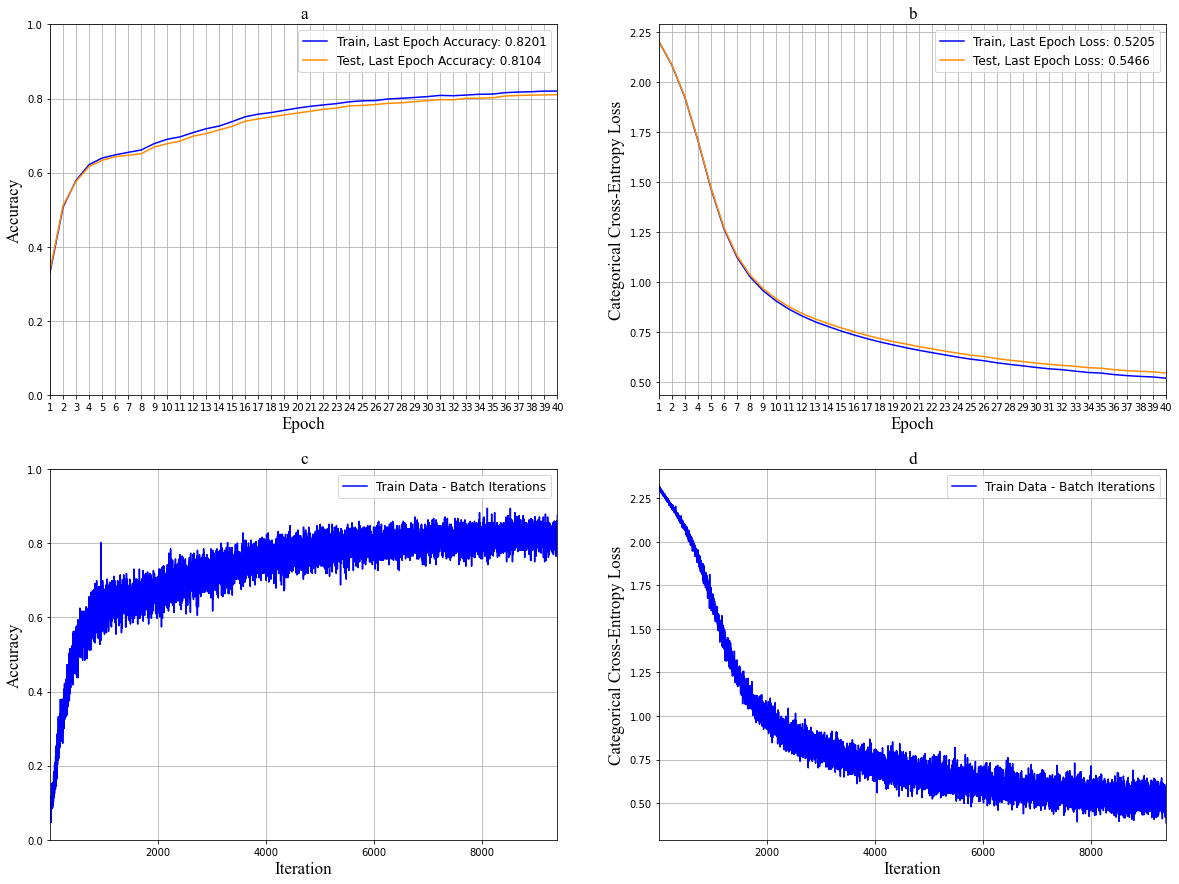

In [300]:
learning_rate = 1e-3
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

train_table = [round(epoch_accuracies[-1], 4), round(epoch_losses[-1], 4)]
test_table = [round(test_epoch_accuracies[-1], 4), round(test_epoch_losses[-1], 4)]
mlp_df_1 = pd.DataFrame([train_table, test_table], columns=['Accuracy', 'Loss'], index=['Train', 'Test'])

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)))
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test, Last Epoch Accuracy: {}'.format(round(test_epoch_accuracies[-1], 4)))
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train, Last Epoch Loss: {}'.format(round(epoch_losses[-1], 4)))
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test, Last Epoch Loss: {}'.format(round(test_epoch_losses[-1], 4)))
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 3:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical cross-entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical cross-entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$.

In [301]:
display(mlp_df_1)

,Accuracy,Loss
Train,0.8201,0.5205
Test,0.8104,0.5466


Here, the accuracy and loss function value of the model is stated for the last epoch, in this case for the $40$'th epoch.

<a name="q112"></a>

#### Task 1.1.2 [^](#outline)

For this task we train the MLP on batches of $256$ data-points for $40$ epochs as before, but this time using learning rates of i) $10^{-5}$ and ii) $10^{-1}$. First we train the MLP model using a learning rate of $10^{-5}$.

In [11]:
# determining the hyper-parameters
learning_rate = 1e-5
batch_size = 256
epochs = 40

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)


MLP Characteristics:
--------------------
MLP Configuration: (784, 400, 400, 400, 400, 400, 10)
Weights shapes: [(400, 784), (400, 400), (400, 400), (400, 400), (400, 400), (10, 400)]             
Biases shapes: [(400,), (400,), (400,), (400,), (400,), (10,)]

Training Complete.



Next we train the MLP model using a learning rate of $10^{-1}$.

In [12]:
# determining the hyper-parameters
learning_rate = 1e-1
batch_size = 256
epochs = 40

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)


MLP Characteristics:
--------------------
MLP Configuration: (784, 400, 400, 400, 400, 400, 10)
Weights shapes: [(400, 784), (400, 400), (400, 400), (400, 400), (400, 400), (10, 400)]             
Biases shapes: [(400,), (400,), (400,), (400,), (400,), (10,)]

Training Complete.



We then plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-5}$, for both the training and the test data, as shown in *Figure 4*.

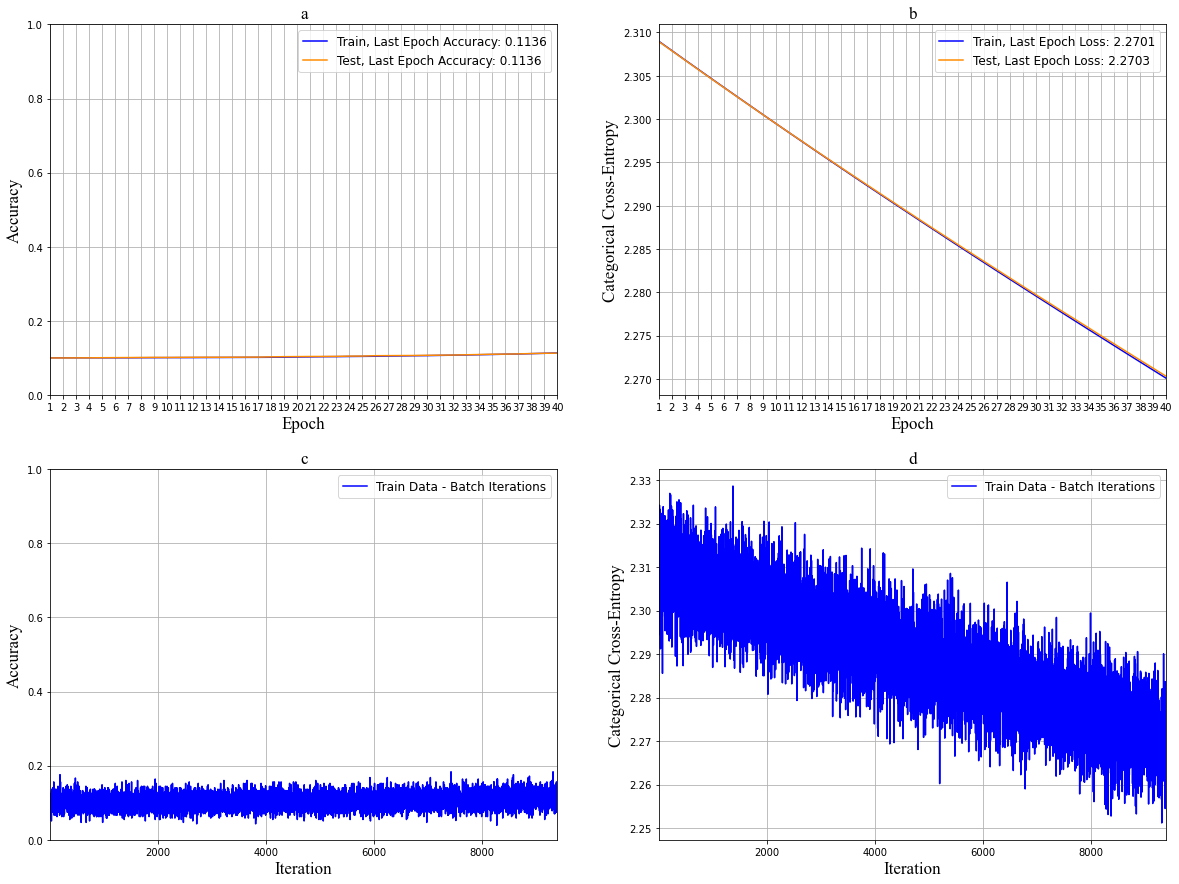

In [277]:
learning_rate = 1e-5
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

train_table = [round(epoch_accuracies[-1], 4), round(epoch_losses[-1], 4)]
test_table = [round(test_epoch_accuracies[-1], 4), round(test_epoch_losses[-1], 4)]
mlp_df_2 = pd.DataFrame([train_table, test_table], columns=['Accuracy', 'Loss'], index=['Train', 'Test'])

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)))
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)))
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train, Last Epoch Loss: {}'.format(round(epoch_losses[-1], 4)))
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test, Last Epoch Loss: {}'.format(round(test_epoch_losses[-1], 4)))
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 4:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical cross-entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical cross-entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-5}$.

In [265]:
display(mlp_df_2)

,Accuracy,Loss
Train,0.1136,2.2701
Test,0.1131,2.2703


Next we plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-1}$, for both the training and the test data, as shown in *Figure 5*.

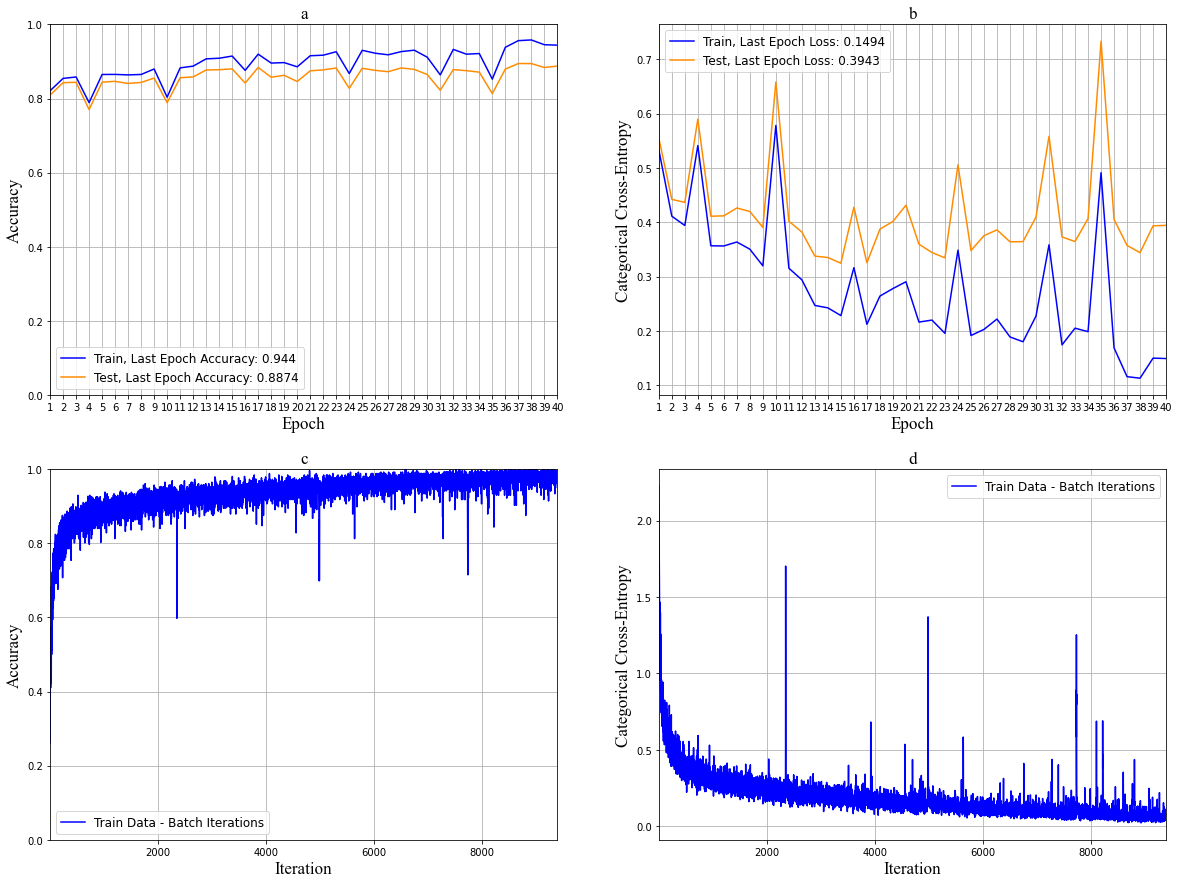

In [278]:
learning_rate = 1e-1
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

train_table = [round(epoch_accuracies[-1], 4), round(epoch_losses[-1], 4)]
test_table = [round(test_epoch_accuracies[-1], 4), round(test_epoch_losses[-1], 4)]
mlp_df_3 = pd.DataFrame([train_table, test_table], columns=['Accuracy', 'Loss'], index=['Train', 'Test'])

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)))
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test, Last Epoch Accuracy: {}'.format(round(test_epoch_accuracies[-1], 4)))
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train, Last Epoch Loss: {}'.format(round(epoch_losses[-1], 4)))
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test, Last Epoch Loss: {}'.format(round(test_epoch_losses[-1], 4)))
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 5:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical cross-entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical cross-entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-1}$.

In [267]:
display(mlp_df_3)

,Accuracy,Loss
Train,0.9440,0.1494
Test,0.8874,0.3943


In order to better assess the effect of the learning rate in terms of the convergence of the loss, we plot the categorical cross-entropy loss of the three models we ran above on the same plot, as shown in *Figure 6*.

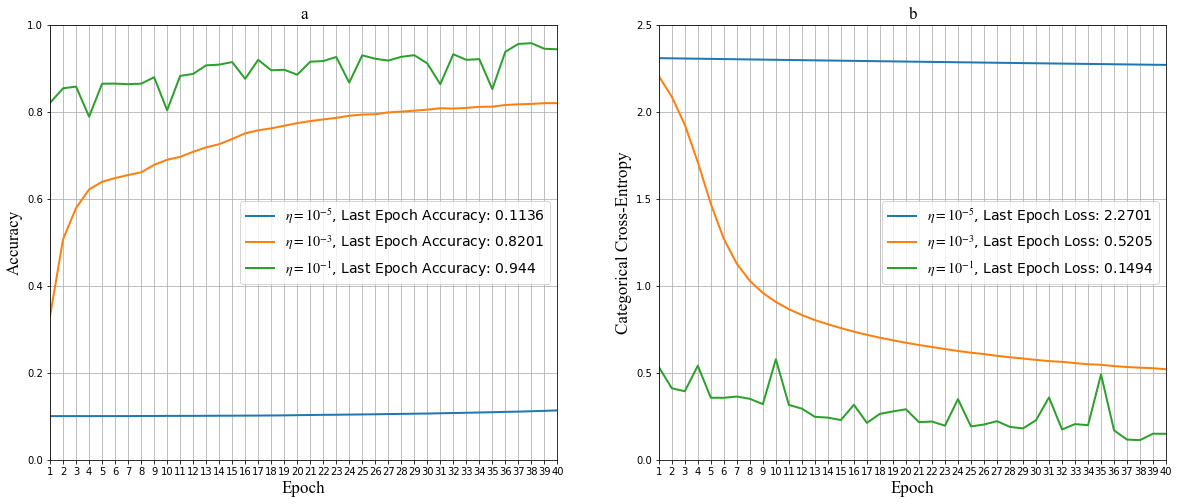

In [317]:
learning_rate = 1e-5
batch_size = 256

epochs = 40
epoch_losses_000001 = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_accuracies_000001 = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

learning_rate = 1e-3
epoch_losses_0001 = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_accuracies_0001 = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

learning_rate = 1e-1
epoch_losses_01 = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_accuracies_01 = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

eta_small = [round(epoch_accuracies_000001[-1], 4), round(epoch_losses_000001[-1], 4)]
eta_medium = [round(epoch_accuracies_0001[-1], 4), round(epoch_losses_0001[-1], 4)]
eta_large = [round(epoch_accuracies_01[-1], 4), round(epoch_losses_01[-1], 4)]
mlp_df_4 = pd.DataFrame([eta_small, eta_medium, eta_large], columns=['Accuracy', 'Loss'], index=[r'$\eta=10^{-5}$', r'$\eta=10^{-3}$', r'$\eta=10^{-1}$'])

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].plot(np.linspace(1, len(epoch_accuracies_000001), len(epoch_accuracies_000001)), epoch_accuracies_000001, label=r'$\eta=10^{-5}$'+', Last Epoch Accuracy: {}'.format(round(epoch_accuracies_000001[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(epoch_accuracies_0001), len(epoch_accuracies_0001)), epoch_accuracies_0001, label=r'$\eta=10^{-3}$'+', Last Epoch Accuracy: {}'.format(round(epoch_accuracies_0001[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(epoch_accuracies_01), len(epoch_accuracies_01)), epoch_accuracies_01, label=r'$\eta=10^{-1}$'+', Last Epoch Accuracy: {}'.format(round(epoch_accuracies_01[-1], 4)), linewidth=2)
axs[0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(np.linspace(1, len(epoch_accuracies_01), len(epoch_accuracies_01)))
axs[0].set_xlim(1, len(epoch_accuracies_01))
axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[1].plot(np.linspace(1, len(epoch_losses_000001), len(epoch_losses_000001)), epoch_losses_000001, label=r'$\eta=10^{-5}$'+', Last Epoch Loss: {}'.format(round(epoch_losses_000001[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(epoch_losses_0001), len(epoch_losses_0001)), epoch_losses_0001, label=r'$\eta=10^{-3}$'+', Last Epoch Loss: {}'.format(round(epoch_losses_0001[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(epoch_losses_01), len(epoch_losses_01)), epoch_losses_01, label=r'$\eta=10^{-1}$'+', Last Epoch Loss: {}'.format(round(epoch_losses_01[-1], 4)), linewidth=2)
axs[1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(np.linspace(1, len(epoch_losses_01), len(epoch_losses_01)))
axs[1].set_xlim(1, len(epoch_losses_01))
axs[1].set_ylim(0, 2.5)
axs[1].legend()
axs[1].grid()
plt.show()

**Figure 6:** a) Accuracy of MLP as a function of epoch for train data. b) Categorical cross-entropy loss function value of MLP as a function of epoch for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=40$, $\text{batch-size}=256$ and learning-rates of $10^{-5}$ (blue), $10^{-3}$ (orange), and $10^{-1}$ (green).

In [271]:
display(mlp_df_4)

,Accuracy,Loss
$\eta=10^{-5}$,0.1136,2.2701
$\eta=10^{-3}$,0.8201,0.5205
$\eta=10^{-1}$,0.9440,0.1494


We can see from *Figure 6* that the loss function value from the train data decreases with increasing learning rate and that the accuracy increases with increasing learning rate. We also observe that a *'small'* learning rate results in a very slow decrease of the loss value, a *'medium'* learning rate results in a smooth decrease of the loss value that seems to converge with time, while a *'large'* learning rate does not converge; it *jumps*. This can be explained with the help of an illustration shown below in *Figure 7*, where for the purposes of visualisation, the loss function is depicted as convex in parameter-space of 1 parameter (in reality the parameter space is much more complex).

![title](./Images/losses.jpg)

**Figure 7:** Sketch of (simplified) convex loss function in single parameter-space, taking $6$ steps with three different learning rates from the same starting position a) *'small'* learning rate, b) *'medium'* learning rate, c) *'large'* learning rate.

*Figure 7* demonstrates that the learning rate heavily affects the speed of convergence. With a *'small'* learning rate, the decrease in loss value is more precise but very slow, while it is also possible that the model gets *stuck* in a local minimum of the loss function, hence the very slow increase in accuracy observed in *Figure 6*. On the other hand, using a *'large'* learning rate results in large jumps across the loss function which may miss the global minimum value, hence we observe divergent curves in *Figure 6*. Using a *'medium'* learning rate provides a good balance in order to efficiently and smoothly converge, and a hyper-parameter search would allow us to fine-tune the learning-rate to the optimum value. In addition, a variable, epoch-dependent learning rate, i.e., learning rate annealing, would enable us to use a larger learning rate to broadly explore the loss function and decrease the learning rate in regions of low loss function values (and thus of high accuracy).

The figure below demonstrates this behaviour, showing how the larger learning rate resulted in a higher accuracy and lower loss (as shown in *Figure 6*), however, it also shows that after a limit the training error increases. Hence, the goal is not to use a very large learning rate, but to fine-tune it instead.

![title](./Images/learning_rate_error.jpg)

**Source**: [1] Goodfellow, I., et. al., (2016), 'Deep Learning'

<a name="q113"></a>

#### Task 1.1.3 [^](#outline)

Finally, for this task, we train the MLP for $80$ epochs, using batches of $256$ data-points and a learning rate of $10^{-3}$.

In [18]:
# determining the hyper-parameters
learning_rate = 1e-3
batch_size = 256
epochs = 80

# determining the structure of the MLP network
mlp_config = (n_input, 400, 400, 400, 400, 400, n_classes)
mlp = MLP(mlp_config)
print(mlp)
mlp.train(x_train, y_train, x_test, y_test, learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)
mlp.save_results(learning_rate=learning_rate, batch_size=batch_size, epochs=epochs)


MLP Characteristics:
--------------------
MLP Configuration: (784, 400, 400, 400, 400, 400, 10)
Weights shapes: [(400, 784), (400, 400), (400, 400), (400, 400), (400, 400), (10, 400)]             
Biases shapes: [(400,), (400,), (400,), (400,), (400,), (10,)]

Training Complete.



We then plot the loss function value and the accuracy obtained from the MLP as a function of the number of epochs with the above set of hyper-parameters: $\text{epochs}=80$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$, for both the training and the test data, as shown in *Figure 8*.

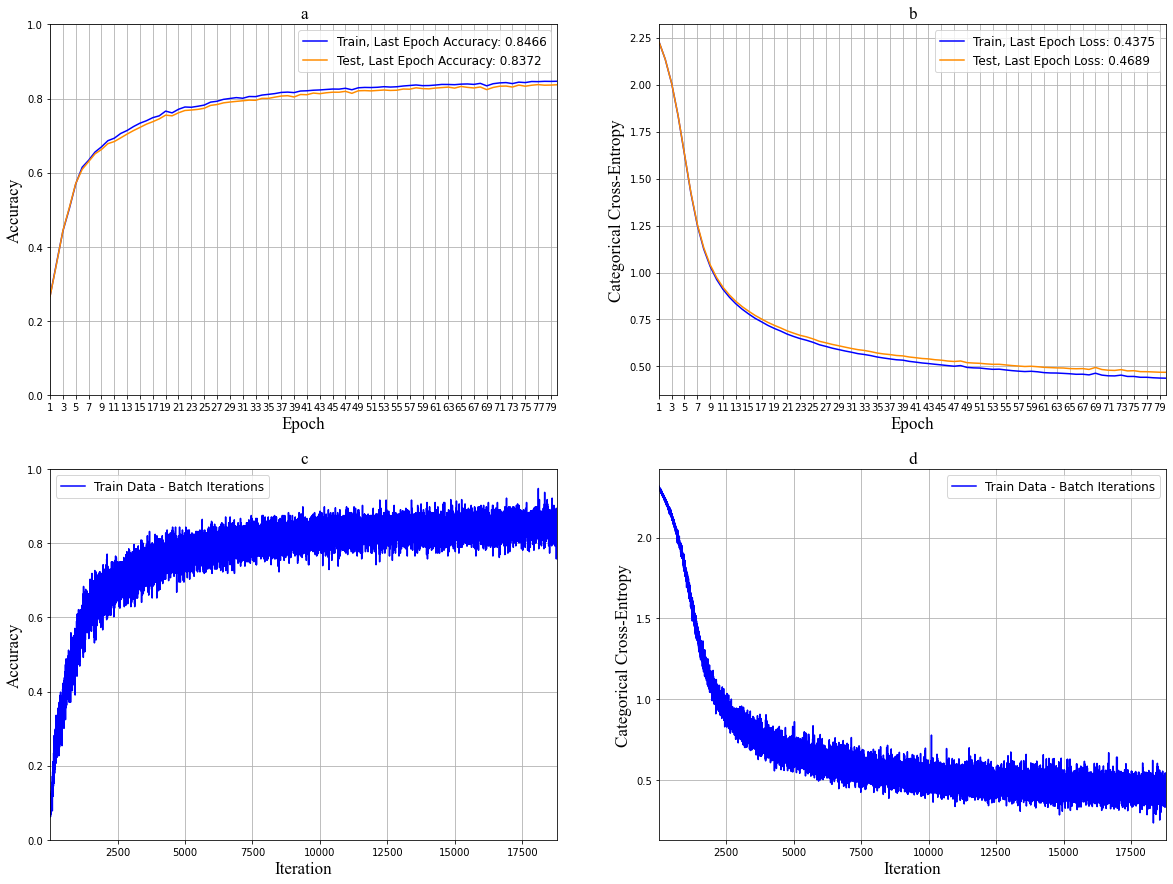

In [280]:
learning_rate = 1e-3
batch_size = 256
epochs = 80

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_accuracies = np.load('npy_objects/batch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
batch_losses = np.load('npy_objects/batch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

train_table = [round(epoch_accuracies[-1], 4), round(epoch_losses[-1], 4)]
test_table = [round(test_epoch_accuracies[-1], 4), round(test_epoch_losses[-1], 4)]
mlp_df_5 = pd.DataFrame([train_table, test_table], columns=['Accuracy', 'Loss'], index=['Train', 'Test'])

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 12}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, color='blue', label='Train, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)))
axs[0,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='Test, Last Epoch Accuracy: {}'.format(round(test_epoch_accuracies[-1], 4)))
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_accuracies))
axs[0,0].set_xticks(np.arange(1, len(epoch_accuracies), 2))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, color='blue', label='Train, Last Epoch Loss: {}'.format(round(epoch_losses[-1], 4)))
axs[0,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='Test, Last Epoch Loss: {}'.format(round(test_epoch_losses[-1], 4)))
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(test_epoch_losses))
axs[0,1].set_xticks(np.arange(1, len(epoch_losses), 2))
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(batch_accuracies), len(batch_accuracies)), batch_accuracies, color='blue', label='Train Data - Batch Iterations')
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(batch_accuracies))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(batch_losses), len(batch_losses)), batch_losses, color='blue', label='Train Data - Batch Iterations')
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Iteration', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(batch_losses))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 8:** a) Accuracy of MLP as a function of epoch for train data (blue) and test data (orange). b) Categorical cross-entropy loss function value of MLP as a function of epoch for train data (blue) and test data (orange). c) Accuracy of MLP as a function of batch iteration for train data. d) Categorical cross-entropy loss function value of MLP as a function of batch iteration for train data. For all plots, the following hyper-parameters were used: $\text{epochs}=80$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$.

In [273]:
display(mlp_df_5)

,Accuracy,Loss
Train,0.8466,0.4375
Test,0.8372,0.4689


In order to compare the differences of increasing the number of epochs from $40$ to $80$ we plot their respective loss and accuracy of the train and test data, shown in *Figure 9* below.

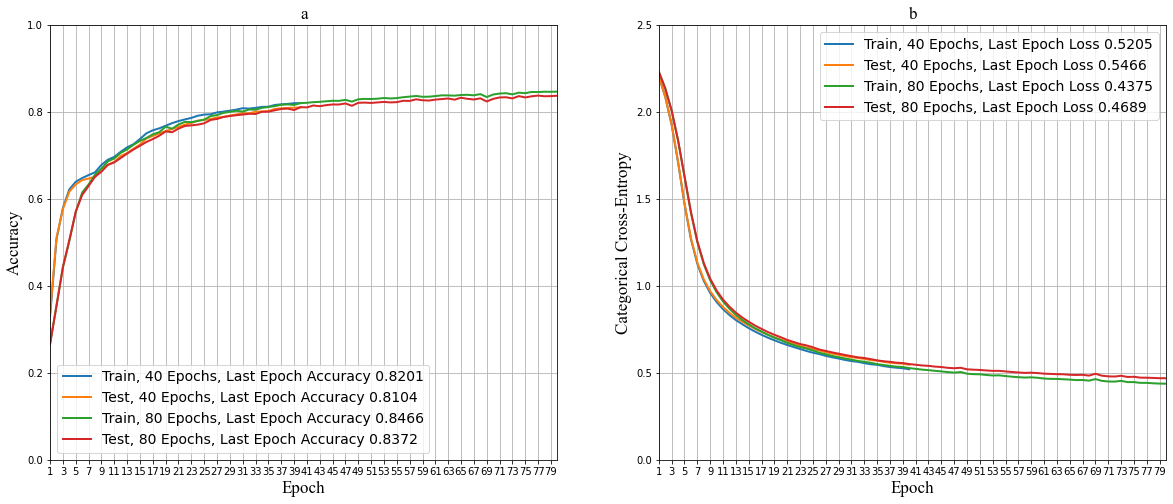

In [318]:
learning_rate = 1e-3
batch_size = 256
epochs = 40

epoch_losses_40 = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_accuracies_40 = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies_40 = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses_40 = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

epochs = 80
epoch_losses_80 = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_accuracies_80 = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies_80 = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses_80 = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)


from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].plot(np.linspace(1, len(epoch_accuracies_40), len(epoch_accuracies_40)), epoch_accuracies_40, label='Train, 40 Epochs, Last Epoch Accuracy {}'.format(round(epoch_accuracies_40[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(test_epoch_accuracies_40), len(test_epoch_accuracies_40)), test_epoch_accuracies_40, label='Test, 40 Epochs, Last Epoch Accuracy {}'.format(round(test_epoch_accuracies_40[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(epoch_accuracies_80), len(epoch_accuracies_80)), epoch_accuracies_80, label='Train, 80 Epochs, Last Epoch Accuracy {}'.format(round(epoch_accuracies_80[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(test_epoch_accuracies_80), len(test_epoch_accuracies_80)), test_epoch_accuracies_80, label='Test, 80 Epochs, Last Epoch Accuracy {}'.format(round(test_epoch_accuracies_80[-1], 4)), linewidth=2)
axs[0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(np.arange(1, len(epoch_accuracies_80), 2))
axs[0].set_xlim(1, len(epoch_accuracies_80))
axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[1].plot(np.linspace(1, len(epoch_losses_40), len(epoch_losses_40)), epoch_losses_40, label='Train, 40 Epochs, Last Epoch Loss {}'.format(round(epoch_losses_40[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(test_epoch_losses_40), len(test_epoch_losses_40)), test_epoch_losses_40, label='Test, 40 Epochs, Last Epoch Loss {}'.format(round(test_epoch_losses_40[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(epoch_losses_80), len(epoch_losses_80)), epoch_losses_80, label='Train, 80 Epochs, Last Epoch Loss {}'.format(round(epoch_losses_80[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(test_epoch_losses_80), len(test_epoch_losses_80)), test_epoch_losses_80, label='Test, 80 Epochs, Last Epoch Loss {}'.format(round(test_epoch_losses_80[-1], 4)), linewidth=2)
axs[1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Categorical Cross-Entropy', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(np.arange(1, len(epoch_losses_80), 2))
axs[1].set_xlim(1, len(epoch_losses_80))
axs[1].set_ylim(0, 2.5)
axs[1].legend()
axs[1].grid()
plt.show()

**Figure 9:** a) Accuracy of MLP as a function of epoch for train and test data. b) Categorical cross-entropy loss function value of MLP as a function of epoch for train and test data. For all plots, the following hyper-parameters were used: $\text{epochs}=80$ (green, red), $\text{epochs}=40$ (blue, orange), $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$.

We can see from *Figure 9* that the two models learned on $40$ and $80$ epochs mostly overlap for the $40$ epochs, as expected since they use the same hyper-parameters: batch size and learning rate. Small deviations are expected and arise from the random initialisation of the weights and the random set of points chosen in each batch. We can tell that neither the $40$ epoch model, nor the $80$ model has overfitted, as the test loss function value is still decreasing at the last epoch. However, we can also observe that the gap in loss value between the train and test data is slightly higher at the end of the $80$ epochs than at the end of the $40$ epochs. This demonstrates that with increasing epochs the model begins to over-fit (although it hasn't overfitted yet) and begins to 'memorise' rather than learn the data, hence, the in-sample (train data) loss decreases faster than the out-of-sample (test data) loss.

Generally, we expect the number of epochs to have the following effect on convergence: a small number of epochs will not allow the model to learn enough and to converge, while too many epochs result in over-fitting and loss of generalisability, as shown in the figure below. We notice that our MLP model has not yet overfitted at $80$ epochs, but we could hypothesise that for more epochs it would begin to overfit, with the test error beginning to increase. In order to avoid this issue, we could use early-stopping - ending the training when the validation error begins to increase.

![title](./Images/early_stopping.png)

**Source**: [2] Goodfellow, I., et. al., (2016), 'Deep Learning', pg. 246

<a name="q12"></a>
<br>
## 1.2 Convolutional Neural Network (CNN) [^](#outline)

A Convolutional Neural Network (CNN) is another kind of artificial neural network different to the MLP, based on the assumptions of ***local connectivity*** and ***equivariance***. Unlike the MLP, a CNN does not consider a vector of values (pixels) for an image, but instead it retains the spatial relations that pixels have, allowing it to learn features of images in different ways using a matrix of pixels. The hidden layers of a CNN perform *convolutions* and are known as **convolutional layers**.

In essence, a convolutional layer uses a kernel (or filter) to apply element-wise multiplication of the pixels of an image, sliding over all pixels. As the convolutional layer 'convolves' an input matrix, it produces a feature map which is passed onto the next layer. Typically, a CNN contains a series of convolutional layers followed by some down-sampling operation (known as pooling), aimed at reducing the spatial dimensions of a layer, keeping its spatial invariance, by obtaining a summary statistic from different parts of the activations of the previous layer. Finally, there can be a number of fully-connected layers before the output layer.

![title](./Images/cnn.png)

**Source:** [3]: Taken from: https://towardsdatascience.com/deep-learning-with-cifar-10-image-classification-64ab92110d79

<a name="q121"></a>

#### Task 1.2.1 [^](#outline)

For this task, we have chosen the following architecture for the CNN:

1. Input layer (28x28)
2. 5 hidden layers:
    - Convolution layer: 3x3 filter, 8 feature maps
    - Convolution layer: 3x3 filter, 8 feature maps
    - Convolution layer: 3x3 filter, 16 feature maps
    - Convolution layer: 3x3 filter, 16 feature maps
    - Max pooling layer: 2x2
3. Fully-connected layer, 64 neurons
4. Output layer, 10 neurons

As for the MLP, the $\text{LeakyReLU}(x)$ activation function will be used with a slope of $\alpha=0.1$ for all layers, except the output layer for which the softmax function will be used. Finally, the optimsation method used will be stochastic gradient descent (SGD) and the loss function will be the categorical cross-entropy loss function.

We import our data again, and then proceed to build our CNN as described above.

In [327]:
def load_data():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)  # convert labels to categorical samples
    y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)
    return (x_train, y_train, x_test, y_test)


x_train, y_train, x_test, y_test = load_data()  # import the data

Here we define a method `get_model()` which uses the TensorFlow package to build the model and each layer within it. We then compile and return the model, using accuracy as its metric.

In [328]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.metrics import categorical_crossentropy


def get_model():
    model = Sequential([
        # Input layer is implicit in 1st convolutional layer
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01), input_shape=(28, 28, 1)),  # First convolutional layer, input: 28x28 image with 1 channel, 8 feature maps, 3x3 filters
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01)),  # 2nd convolutional layer, 8 feature maps, 3x3 filters
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),  # 3rd convolutional layer, 16 feature maps, 3x3 filters
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),  # 4th convolutional layer, 16 feature maps, 3x3 filters
        MaxPooling2D((2, 2)),  # 2x2 max-pooling layer
        Flatten(),  # Flattens 2D max-pooling layer to connect to fully-conected layer
        Dense(64, activation=LeakyReLU(alpha=0.01)),  # fully-connected (dense) layer
        Dense(10, activation='softmax')  # output layer with softmax activation function
    ])
    # model uses categorical cross-entorpy as loss function, using Stochastic Gradient Descent (SGD), with a learning rate of 10^-3 and accuracy as its metric
    model.compile(loss=categorical_crossentropy, optimizer=SGD(learning_rate=1e-3), metrics=['accuracy'])
    return model

We then initialise a model and print its summary to inspect that each layer is correctly built, with the correct shapes and number of parameters.

In [329]:
cnn = get_model()  # obtain the model
cnn_layer_names = [layer.name for layer in cnn.layers]  # obtain the names of all layers to use later in visualisations
print(cnn.summary())  # obtain model summary

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 8)         80        
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 conv2d_2 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 conv2d_3 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 10, 10, 16)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                        

2022-03-25 00:10:11.230696: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-25 00:10:11.230732: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (georgealevras-XPS-15-9570): /proc/driver/nvidia/version does not exist
2022-03-25 00:10:11.231000: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Then, we form data-sets, one for training (containing both the x_train and the y_train) and one for testing (containing both the x_test and the y_test). We then shuffle the datasets to randomise the order of the images and take batches of $256$ images at a time.

In [330]:
# combine the x_train and y_train data in a single train_data object
train_data = tf.data.Dataset.from_tensor_slices((x_train.astype(np.float32), y_train.astype(np.float32)))
train_data = train_data.shuffle(1024)  # shuffles data to randomise order of images
train_data = train_data.batch(256)  # splits training data in batches of size 256

# combine the x_test and y_test data in a single train_data object
test_data = tf.data.Dataset.from_tensor_slices((x_test.astype(np.float32), y_test.astype(np.float32)))
test_data = test_data.batch(256)  # splits test data in batches of size 256

2022-03-25 00:10:14.988297: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-03-25 00:10:15.089578: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 31360000 exceeds 10% of free system memory.


We train the model for $40$ epochs (using batches of $256$ data-points and a learning rate of $\eta=10^{-3}$) and plot the accuracy and loss function values as a function of the number of epochs, shown in *Figure 10*.

In [331]:
history = cnn.fit(train_data, validation_data=test_data, epochs=40, verbose=0)  # train the CNN and evaluate it on the test data for 40 epochs

# Here, the outputs (train and test loss and accuracy) are saved in .npy files in order to not have to re-run
cnn_1_2_1_train_loss = history.history['loss']
cnn_1_2_1_train_acc = history.history['accuracy']
cnn_1_2_1_test_loss = history.history['val_loss']
cnn_1_2_1_test_acc = history.history['val_accuracy']
np.save(os.path.join('npy_objects', 'cnn_1_2_1_train_loss'), np.array(cnn_1_2_1_train_loss))
np.save(os.path.join('npy_objects', 'cnn_1_2_1_train_acc'), np.array(cnn_1_2_1_train_acc))
np.save(os.path.join('npy_objects', 'cnn_1_2_1_test_loss'), np.array(cnn_1_2_1_test_loss))
np.save(os.path.join('npy_objects', 'cnn_1_2_1_test_acc'), np.array(cnn_1_2_1_test_acc))

2022-03-25 00:10:23.906899: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-03-25 00:10:24.041589: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 188160000 exceeds 10% of free system memory.
2022-03-25 00:10:24.545137: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 27417600 exceeds 10% of free system memory.


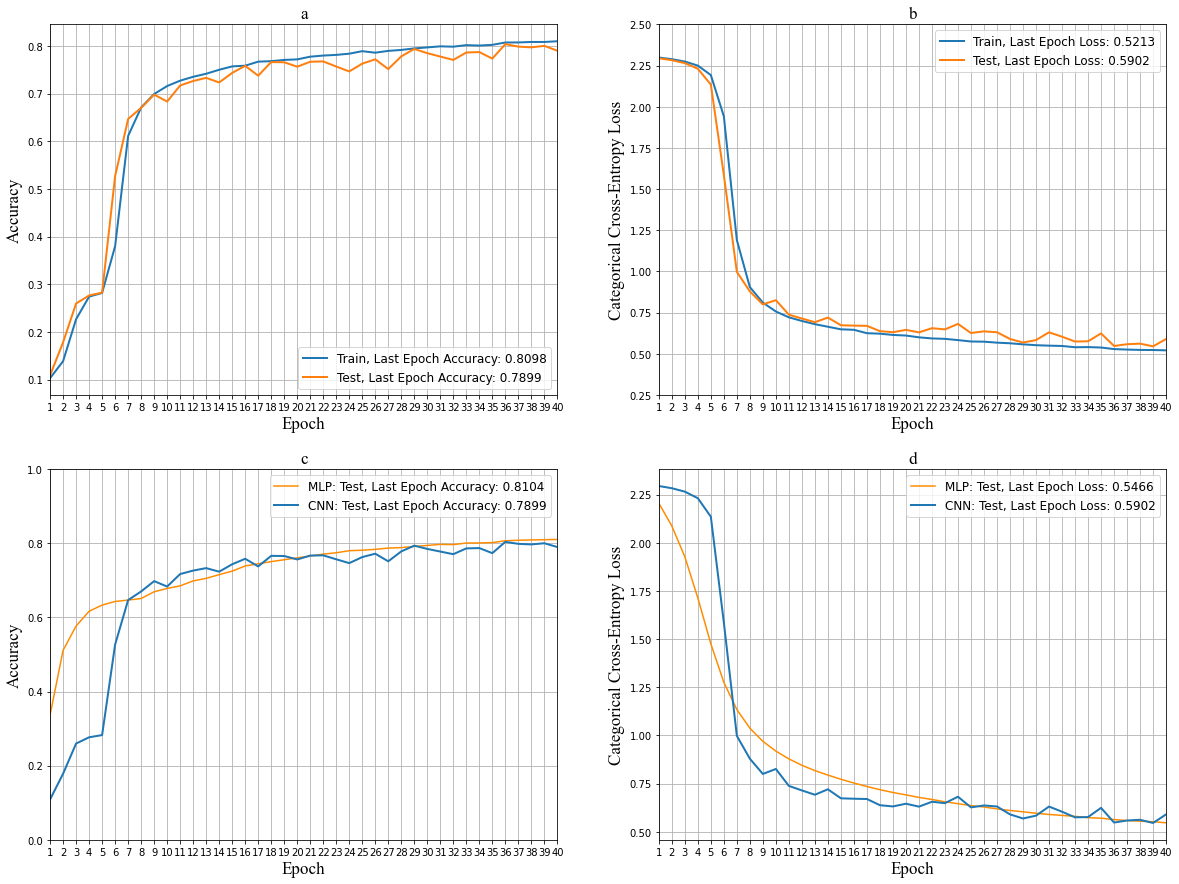

In [292]:
cnn_1_2_1_train_loss = np.load('npy_objects/cnn_1_2_1_train_loss.npy', allow_pickle=True)
cnn_1_2_1_train_acc = np.load('npy_objects/cnn_1_2_1_train_acc.npy', allow_pickle=True)
cnn_1_2_1_test_loss = np.load('npy_objects/cnn_1_2_1_test_loss.npy', allow_pickle=True)
cnn_1_2_1_test_acc = np.load('npy_objects/cnn_1_2_1_test_acc.npy', allow_pickle=True)

learning_rate = 1e-3
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)

fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(cnn_1_2_1_train_acc), len(cnn_1_2_1_train_acc)), cnn_1_2_1_train_acc, label='Train, Last Epoch Accuracy: {}'.format(round(cnn_1_2_1_train_acc[-1], 4)), linewidth=2)
axs[0,0].plot(np.linspace(1, len(cnn_1_2_1_train_acc), len(cnn_1_2_1_train_acc)), cnn_1_2_1_test_acc, label='Test, Last Epoch Accuracy: {}'.format(round(cnn_1_2_1_test_acc[-1], 4)), linewidth=2)
axs[0,0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(test_epoch_losses))
axs[0,0].set_xticks(np.linspace(1, len(cnn_1_2_1_train_acc), len(cnn_1_2_1_train_acc)))
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(cnn_1_2_1_train_loss), len(cnn_1_2_1_train_loss)), cnn_1_2_1_train_loss, label='Train, Last Epoch Loss: {}'.format(round(cnn_1_2_1_train_loss[-1], 4)), linewidth=2)
axs[0,1].plot(np.linspace(1, len(cnn_1_2_1_test_loss), len(cnn_1_2_1_test_loss)), cnn_1_2_1_test_loss, label='Test, Last Epoch Loss: {}'.format(round(cnn_1_2_1_test_loss[-1], 4)), linewidth=2)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[0,1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(cnn_1_2_1_train_loss))
axs[0,1].set_xticks(np.linspace(1, len(cnn_1_2_1_train_loss), len(cnn_1_2_1_train_loss)))
axs[0,1].set_ylim(0.25, 2.5)
axs[0,1].grid()
axs[0,1].legend()

axs[1,0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, color='darkorange', label='MLP: Test, Last Epoch Accuracy: {}'.format(round(test_epoch_accuracies[-1], 4)))
axs[1,0].plot(np.linspace(1, len(cnn_1_2_1_train_acc), len(cnn_1_2_1_train_acc)), cnn_1_2_1_test_acc, label='CNN: Test, Last Epoch Accuracy: {}'.format(round(cnn_1_2_1_test_acc[-1], 4)), linewidth=2)
axs[1,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(test_epoch_accuracies))
axs[1,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, color='darkorange', label='MLP: Test, Last Epoch Loss: {}'.format(round(test_epoch_losses[-1], 4)))
axs[1,1].plot(np.linspace(1, len(cnn_1_2_1_test_loss), len(cnn_1_2_1_test_loss)), cnn_1_2_1_test_loss, label='CNN: Test, Last Epoch Loss: {}'.format(round(cnn_1_2_1_test_loss[-1], 4)), linewidth=2)
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(test_epoch_losses))
axs[1,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 10:** a) Accuracy of CNN as a function of epoch for train data (blue) and test data (orange). b) Categorical cross-entropy loss function value of CNN as a function of epoch for train data (blue) and test data (orange). c) Accuracy of CNN (blue) and MLP (orange) as a function of epoch for test data. d) Categorical cross-entropy loss function value of CNN (blue) and MLP (orange) as a function of epoch. For all plots, the following hyper-parameters were used: $\text{epochs}=40$, $\text{batch-size}=256$, $\text{learning rate}=\eta=10^{-3}$.

From *Figure 10* a) and b) we can see that the CNN has probably reached a peak accuracy and minimum loss function value, as the test accuracy and loss do not change significantly between epochs $30$ and $40$. However, the test accuracy is not very smooth, it has small jumps. We also notice that the MLP starts with a slightly lower loss than the CNN, however the CNN has converges faster than the MLP, seen by the more quick and abrupt decrease of the loss curve in *Figure 10* b). Comparing how the CNN performs in comparison to the MLP in terms of the accuracy of the test data by looking at *Figure 10* c) we see that the MLP has slightly higher accuracy at $0.8104$ (compared to $0.7899$ for the CNN) and slightly lower loss function value at $0.5466$ (compared to $0.5902$ for the CNN). We also see that the MLP test curves are smoother and seem to converge a little better than the CNN.

<a name="q122"></a>

#### Task 1.2.2 [^](#outline)

In this section we introduce dropout regularisation.

Dropout is a regularisation technique which affects the behaviour of the neurons in a neural network such as our CNN, which randomly sets neurons to $0$ according to a Bernoulli mask with probability $p$, the equivalent of setting all of their weights to $0$. The proportion of the neurons that are set to $0$ is the ***dropout rate***, e.g., a dropout rate of $0.2$ sets $20$% of the neurons to $0$. This technique aims to reduce over-fitting that may occur from neurons beginning to 'co-adapt' too much; that is, it becomes a lot harder for neurons in the network to depend too much on the presence of a any specific neuron, thus, the model learns to generalise more.

Below, we modify our CNN defining a new method `get_model_dropout` which incorporates dropout in the fully-connected layer, thus zero-ing out (dropping) some of its neurons.

In [21]:
from tensorflow.keras.layers import Dropout

def get_model_dropout(rate):
    model = Sequential([
        # Input layer is implicit in 1st convolutional layer
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01), input_shape=(28, 28, 1)),  # First convolutional layer, input: 28x28 image with 1 channel, 8 feature maps, 3x3 filters
        Conv2D(8, (3, 3), activation=LeakyReLU(alpha=0.01)),  # 2nd convolutional layer, 8 feature maps, 3x3 filters
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),  # 3rd convolutional layer, 16 feature maps, 3x3 filters
        Conv2D(16, (3, 3), activation=LeakyReLU(alpha=0.01)),  # 4th convolutional layer, 16 feature maps, 3x3 filters
        MaxPooling2D((2, 2)),  # 2x2 max-pooling layer
        Flatten(),  # Flattens 2D max-pooling layer to connect to fully-conected layer
        Dense(64, activation=LeakyReLU(alpha=0.01)),  # fully-connected (dense) layer
        Dropout(rate),  # Incorporates dropout in the fully connected layer
        Dense(10, activation='softmax')  # output layer with softmax activation function
    ])
    # model uses categorical cross-entorpy as loss function, using Stochastic Gradient Descent (SGD), with a learning rate of 10^-3 and accuracy as its metric
    model.compile(loss=categorical_crossentropy, optimizer=SGD(learning_rate=1e-3), metrics=['accuracy'])
    return model


Once we have incorporated dropout, we want to find out what is the optimal dropout rate; what is the rate that maximises the accuracy on a validation set during training.

As a result, we split our training data-set into training and validation with an 80:20 split respectively, and use the accuracy of the validation set as a metric for the performance of the CNN model with dropout. We then scan a range of different dropout rates in the range $[0.1, 0.9]$ with increments of $0.1$ and record the accuracy of the validation data-set. We finally return the dropout rate which maximises the validation accuracy.

In [105]:
split_rate = 0.8  # Split between train and validation of 80:20 respectively
x_train_split, x_val_split = np.split(x_train, [int(split_rate*(x_train.shape[0]))])  # perform the split on the x
y_train_split, y_val_split = np.split(y_train, [int(split_rate*(y_train.shape[0]))])  # perform the split on the y

# combine the x_train and y_train data in a single train_data object
train_data_122 = tf.data.Dataset.from_tensor_slices((x_train_split.astype(np.float32), y_train_split.astype(np.float32)))
train_data_122 = train_data_122.shuffle(1024)  # shuffles data to randomise order of images
train_data_122 = train_data_122.batch(256)  # splits training data in batches of size 256

# combine the x_test and y_test data in a single train_data object
val_data_122 = tf.data.Dataset.from_tensor_slices((x_val_split.astype(np.float32), y_val_split.astype(np.float32)))
val_data_122 = val_data_122.batch(256)  # splits test data in batches of size 256

# These arrays will hold the training and validation accuracy and losses for each dropout hyper-parameter
train_losses_122 = []
train_accs_122 = []
val_losses_122 = []
val_accs_122 = []
for d in np.linspace(0.1, 0.9, 9):  # loop through 9 dropout values [0.1, 0.9]
    cnn_dropout = get_model_dropout(d)  # obtain a model with a given dropout value d
    history_dropout = cnn_dropout.fit(train_data_122, validation_data=val_data_122, epochs=40, verbose=0)    # train the CNN with dropout and evaluate it on the test data for 40 epochs
    
    # obtain and append train and validation accuracy and loss to arrays
    train_losses_122.append(history_dropout.history['loss'])
    train_accs_122.append(history_dropout.history['accuracy'])
    val_losses_122.append(history_dropout.history['val_loss'])
    val_accs_122.append(history_dropout.history['val_accuracy'])
    
    print('Checking dropout rate d={}'.format(round(d, 1)))
    
np.save(os.path.join('npy_objects', 'train_losses_122'), np.array(train_losses_122))
np.save(os.path.join('npy_objects', 'train_accs_122'), np.array(train_accs_122))
np.save(os.path.join('npy_objects', 'val_losses_122'), np.array(val_losses_122))
np.save(os.path.join('npy_objects', 'val_accs_122'), np.array(val_accs_122))

Checking dropout rate d=0.1
Checking dropout rate d=0.2
Checking dropout rate d=0.3
Checking dropout rate d=0.4
Checking dropout rate d=0.5
Checking dropout rate d=0.6
Checking dropout rate d=0.7
Checking dropout rate d=0.8
Checking dropout rate d=0.9


Having performed our dropout-rate search, we plot the validation accuracy and validation loss function curves as a function of the number of epochs, shown in *Figure 11*.

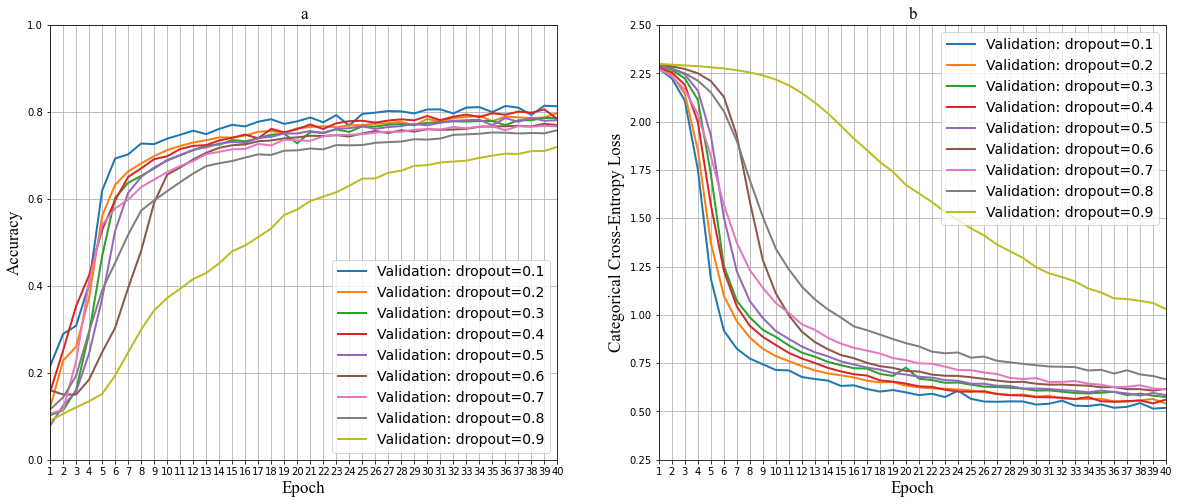

In [319]:
train_losses_122 = np.load('npy_objects/train_losses_122.npy', allow_pickle=True)
train_accs_122 = np.load('npy_objects/train_accs_122.npy', allow_pickle=True)
val_losses_122 = np.load('npy_objects/val_losses_122.npy', allow_pickle=True)
val_accs_122 = np.load('npy_objects/val_accs_122.npy', allow_pickle=True)


from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
for i in range(len(val_accs_122)):
    axs[0].plot(np.linspace(1, len(val_accs_122[i]), len(val_accs_122[i])), val_accs_122[i], label='Validation: dropout={}'.format(round(0.1+i*0.1, 1)), linewidth=2)
axs[0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(np.linspace(1, len(val_accs_122[0]), len(val_accs_122[0])))
axs[0].set_xlim(1, len(val_accs_122[i]))
axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
for i in range(len(val_losses_122)):
    axs[1].plot(np.linspace(1, len(val_losses_122[i]), len(val_losses_122[i])), val_losses_122[i], label='Validation: dropout={}'.format(round(0.1+i*0.1, 1)), linewidth=2)
axs[1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(np.linspace(1, len(val_losses_122[0]), len(val_losses_122[0])))
axs[1].set_xlim(1, len(val_losses_122[i]))
axs[1].set_ylim(0.25, 2.5)
axs[1].legend()
axs[1].grid()
plt.show()

**Figure 11**: a) Accuracy of validation data-set for CNN with dropout for a range of dropout rates: $[0.1, 0.9]$ at $0.1$ increments. b) Categorical cross-entropy loss function value of validation data-set for CNN with dropout for a range of dropout rates: $[0.1, 0.9]$ at $0.1$ increments. Part a) shows that a dropout rate of $0.1$ results in the highest validation accuracy.

We then obtain the accuracy from the last epoch from each validation accuracy curve as our final accuracy measure, and plot that as a function of dropout rate in *Figure 12* in order to find the ***optimum dropout rate***.

In [23]:
# Obtain the validation accuracy from the last epoch for each model (with different dropout rate)
val_accs_with_dropout_last = [val_accs_122[i][-1] for i in range(len(val_accs_122))]

dropouts = np.linspace(0.1, 0.9, 9)

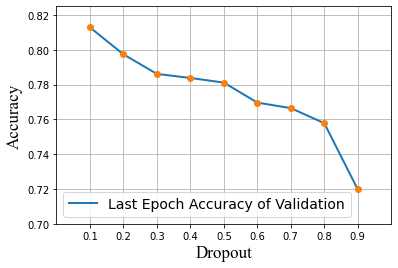

In [401]:
from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

plt.plot(dropouts, val_accs_with_dropout_last, label='Last Epoch Accuracy of Validation', linewidth=2)
plt.plot(dropouts, val_accs_with_dropout_last, 'o')
plt.xlabel('Dropout', fontname='Times New Roman', fontsize=17)
plt.ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
plt.xticks(dropouts)
plt.xlim(0, 1)
plt.ylim(0.7, 0.825)
plt.legend()
plt.grid()
plt.show()

*Figure 12*: Accuracy of the validation data-set (obtained from the last epoch of each validation accuracy curve) as a function of the dropout rate. A dropout rate of $0.1$ results in the highest validation accuracy.

Having search through a range of different dropout rates, we then fix the optimal dropout rate (that which maximises the validation accuracy) and retrain the CNN model on the entire train data-set, incorporating dropout with the optimal dropout rate.

In [25]:
optimum_dropout = dropouts[np.argmax(val_accs_with_dropout_last)]  # Optimum dropout is the one which maximises validation accuracy

In [26]:
cnn_optimum_dropout = get_model_dropout(optimum_dropout)  # obtain a new CNN with dropout model, using the optimum dropout layer obtained
cnn_optimum_layer_names = [layer.name for layer in cnn_optimum_dropout.layers]  # obtain names of layers to use later in visualisation
print(cnn_optimum_dropout.summary())  # obtain model summary

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 conv2d_6 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 conv2d_7 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                      

In [34]:
history_optimum_dropout = cnn_optimum_dropout.fit(train_data, validation_data=test_data, epochs=40, verbose=0)    # train the CNN and evaluate it on the test data for 40 epochs

# Here, the outputs (train and test loss and accuracy) are saved in .npy files in order to not have to re-run
cnn_1_2_2_train_loss = history_optimum_dropout.history['loss']
cnn_1_2_2_train_acc = history_optimum_dropout.history['accuracy']
cnn_1_2_2_test_loss = history_optimum_dropout.history['val_loss']
cnn_1_2_2_test_acc = history_optimum_dropout.history['val_accuracy']
np.save(os.path.join('npy_objects', 'cnn_1_2_2_train_loss'), np.array(cnn_1_2_2_train_loss))
np.save(os.path.join('npy_objects', 'cnn_1_2_2_train_acc'), np.array(cnn_1_2_2_train_acc))
np.save(os.path.join('npy_objects', 'cnn_1_2_2_test_loss'), np.array(cnn_1_2_2_test_loss))
np.save(os.path.join('npy_objects', 'cnn_1_2_2_test_acc'), np.array(cnn_1_2_2_test_acc))

We then evaluate and plot the loss and accuracy of both the training and test sets as a function of the number of epochs in order to compare them for the CNN model with no dropout rate, and with the optimal dropout rate, as shown in *Figure 13*.

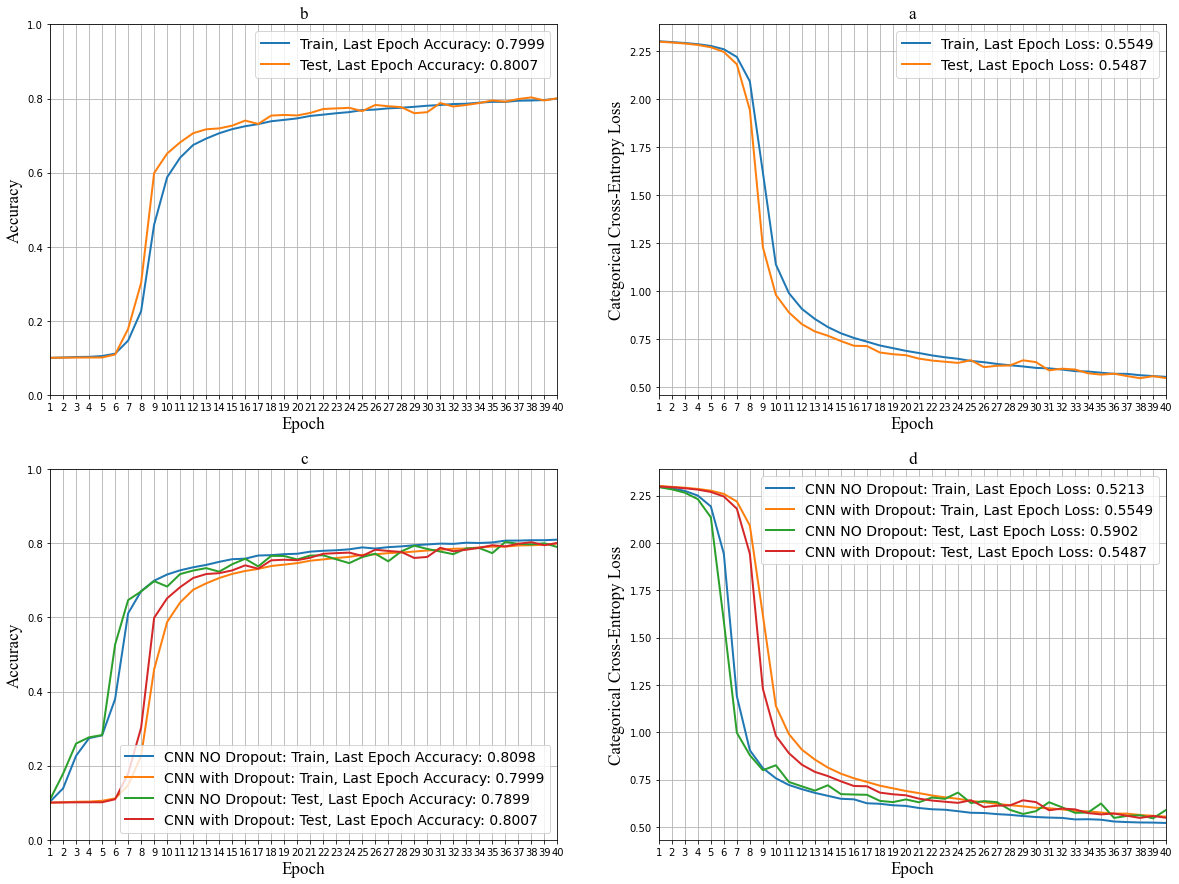

In [324]:
cnn_1_2_2_train_loss = np.load('npy_objects/cnn_1_2_2_train_loss.npy', allow_pickle=True)
cnn_1_2_2_train_acc = np.load('npy_objects/cnn_1_2_2_train_acc.npy', allow_pickle=True)
cnn_1_2_2_test_loss = np.load('npy_objects/cnn_1_2_2_test_loss.npy', allow_pickle=True)
cnn_1_2_2_test_acc = np.load('npy_objects/cnn_1_2_2_test_acc.npy', allow_pickle=True)

cnn_1_2_1_train_loss = np.load('npy_objects/cnn_1_2_1_train_loss.npy', allow_pickle=True)
cnn_1_2_1_train_acc = np.load('npy_objects/cnn_1_2_1_train_acc.npy', allow_pickle=True)
cnn_1_2_1_test_loss = np.load('npy_objects/cnn_1_2_1_test_loss.npy', allow_pickle=True)
cnn_1_2_1_test_acc = np.load('npy_objects/cnn_1_2_1_test_acc.npy', allow_pickle=True)

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(2, 2, figsize=(20,15))
axs[0,0].plot(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)), cnn_1_2_2_train_acc, label='Train, Last Epoch Accuracy: {}'.format(round(cnn_1_2_2_train_acc[-1], 4)), linewidth=2)
axs[0,0].plot(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)), cnn_1_2_2_test_acc, label='Test, Last Epoch Accuracy: {}'.format(round(cnn_1_2_2_test_acc[-1], 4)), linewidth=2)
axs[0,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0,0].set_title('b', fontname='Times New Roman', fontsize=17)
axs[0,0].set_xlim(1, len(cnn_1_2_2_train_acc))
axs[0,0].set_xticks(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)))
axs[0,0].set_ylim(0, 1)
axs[0,0].grid()
axs[0,0].legend()

axs[0,1].plot(np.linspace(1, len(cnn_1_2_2_train_loss), len(cnn_1_2_2_train_loss)), cnn_1_2_2_train_loss, label='Train, Last Epoch Loss: {}'.format(round(cnn_1_2_2_train_loss[-1], 4)), linewidth=2)
axs[0,1].plot(np.linspace(1, len(cnn_1_2_2_test_loss), len(cnn_1_2_2_test_loss)), cnn_1_2_2_test_loss, label='Test, Last Epoch Loss: {}'.format(round(cnn_1_2_2_test_loss[-1], 4)), linewidth=2)
axs[0,1].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0,1].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[0,1].set_xlim(1, len(cnn_1_2_2_train_loss))
axs[0,1].set_xticks(np.linspace(1, len(cnn_1_2_2_train_loss), len(cnn_1_2_2_train_loss)))
axs[0,1].grid()
axs[0,1].legend()

axs[1, 0].plot(np.linspace(1, len(cnn_1_2_1_train_acc), len(cnn_1_2_1_train_acc)), cnn_1_2_1_train_acc, label='CNN NO Dropout: Train, Last Epoch Accuracy: {}'.format(round(cnn_1_2_1_train_acc[-1], 4)), linewidth=2)
axs[1,0].plot(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)), cnn_1_2_2_train_acc, label='CNN with Dropout: Train, Last Epoch Accuracy: {}'.format(round(cnn_1_2_2_train_acc[-1], 4)), linewidth=2)
axs[1,0].plot(np.linspace(1, len(cnn_1_2_1_train_acc), len(cnn_1_2_1_train_acc)), cnn_1_2_1_test_acc, label='CNN NO Dropout: Test, Last Epoch Accuracy: {}'.format(round(cnn_1_2_1_test_acc[-1], 4)), linewidth=2)
axs[1,0].plot(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)), cnn_1_2_2_test_acc, label='CNN with Dropout: Test, Last Epoch Accuracy: {}'.format(round(cnn_1_2_2_test_acc[-1], 4)), linewidth=2)
axs[1,0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1,0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[1,0].set_title('c', fontname='Times New Roman', fontsize=17)
axs[1,0].set_xlim(1, len(test_epoch_accuracies))
axs[1,0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[1,0].set_ylim(0, 1)
axs[1,0].grid()
axs[1,0].legend()

axs[1,1].plot(np.linspace(1, len(cnn_1_2_1_train_acc), len(cnn_1_2_1_train_acc)), cnn_1_2_1_train_loss, label='CNN NO Dropout: Train, Last Epoch Loss: {}'.format(round(cnn_1_2_1_train_loss[-1], 4)), linewidth=2)
axs[1,1].plot(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)), cnn_1_2_2_train_loss, label='CNN with Dropout: Train, Last Epoch Loss: {}'.format(round(cnn_1_2_2_train_loss[-1], 4)), linewidth=2)
axs[1,1].plot(np.linspace(1, len(cnn_1_2_1_test_loss), len(cnn_1_2_1_test_loss)), cnn_1_2_1_test_loss, label='CNN NO Dropout: Test, Last Epoch Loss: {}'.format(round(cnn_1_2_1_test_loss[-1], 4)), linewidth=2)
axs[1,1].plot(np.linspace(1, len(cnn_1_2_2_test_loss), len(cnn_1_2_2_test_loss)), cnn_1_2_2_test_loss, label='CNN with Dropout: Test, Last Epoch Loss: {}'.format(round(cnn_1_2_2_test_loss[-1], 4)), linewidth=2)
axs[1,1].set_title('d', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1,1].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[1,1].set_xlim(1, len(test_epoch_losses))
axs[1,1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[1,1].grid()
axs[1,1].legend()

plt.show()

**Figure 13**: a) Accuracy of the train data (blue) and the test data (orange) for the CNN model with the optimal dropout rate (0.1) as a function of the number of epochs. b) Categorical cross-entropy of the train data (blue) and the test data (orange) for the CNN model with the optimal dropout rate (0.1) as a function of the number of epochs. c) Accuracy of the train and test data for the CNN model with no dropout rate and for the CNN model with the optimal dropout rate. d) Categorical cross-entropy of the train and test data for the CNN model with no dropout rate and for the CNN model with the optimal dropout rate.

We notice from *Figure 13* that for the CNN model with optimal dropout rate the test accuracy is slightly higher at $0.8007$ than the train accuracy at $0.7999$. The difference is really small, however, such behaviour can occur as the model only uses the non-dropped neurons to perform the training but is then allowed to use all of the neurons to evaluate the test data-set, even the ones dropped for training. As a result, it is possible for the test accuracy to become higher than the train accuracy, having a more robust model with all the neurons active but whose training occured with optimal dropout.

When comparing the CNN model with optimal dropout to the one without, we notice that the CNN model with optimal dropout has better generalisability; this is evident as its test accuracy is higher than its training accuracy, and the curve is also a lot less 'jumpy' than that of the CNN model without dropout. The jumpiness of the CNN model without dropout demonstrates that it is more sensitive to noise. This is also evident as the gap between the train and test curves is a lot smaller for CNN with dropout than CNN without dropout, both for the accuracy and the loss curves. The model with optimal dropout over-fits less as the neurons do not co-adapt, and hence it has better generalisability with lower test loss at $0.5487$ than the training data at $0.5549$. We also notice that although the CNN model without dropout converges faster than the CNN model with dropout - it begins with higher accuracy and lower loss than the CNN model with optimal dropout and reaches better values quicker. However, this reverses after about 25 epochs. This occurs because the CNN model without dropout is able to achieve higher accuracy initially as neurons can co-adapt, but over time, the CNN model with dropout over-performs as it is able to generalise better and not overfit as much. With regards to the features, during training neurons in the model with dropout are able to learn more robust features that are more meaningful and less noisy, while the non-dropout CNN model's neurons grow a dependence on particular features to predict. This can be shown by plotting a histogram of the activations of the hidden units of the fully connected layer (when the model is evaluated on the test set), where there is sparsity in the weights of the CNN with dropout, thus we expect fewer hidden units with activations different to or larger from 0; we expect a distribution that is closer to $0$ when there is dropout compared to without, as demonstrated by *Figure 14* below.

In [36]:
from tensorflow.keras.models import Model

inputs = cnn.inputs  # obtain inputs from CNN model
layer_names = [cnn_layer_names[6]]  # choose the fully-dense layer (indexed 6)
outputs = [cnn.get_layer(layer_name).output for layer_name in layer_names]  # obtain the outputs of the fully-dense layer (activations)
cnn_features = Model(inputs=inputs, outputs=outputs)  # obtain the CNN features for the specified inputs and outputs
features_cnn = cnn_features.predict(x_test)  # make a prediction using the CNN features selected on the test data
np.save(os.path.join('npy_objects', 'features_cnn'), np.array(features_cnn))

inputs_optimum_dropout = cnn_optimum_dropout.inputs  # obtain inputs from CNN-with-optimum-dropout model
layer_names_optimum_dropout = [cnn_optimum_layer_names[6]]  # choose the fully-dense layer (indexed 6)
outputs_optimum_dropout = [cnn_optimum_dropout.get_layer(layer_name).output for layer_name in layer_names_optimum_dropout]  # obtain the outputs of the fully-dense layer (activations)
cnn_features_optimum_dropout = Model(inputs=inputs_optimum_dropout, outputs=outputs_optimum_dropout)  # obtain the CNN-with-optimum-dropout features for the specified inputs and outputs
features_optimum_dropout = cnn_features_optimum_dropout.predict(x_test)  # make a prediction using the CNN-with-optimum-dropout features selected on the test data
np.save(os.path.join('npy_objects', 'features_optimum_dropout'), np.array(features_optimum_dropout))

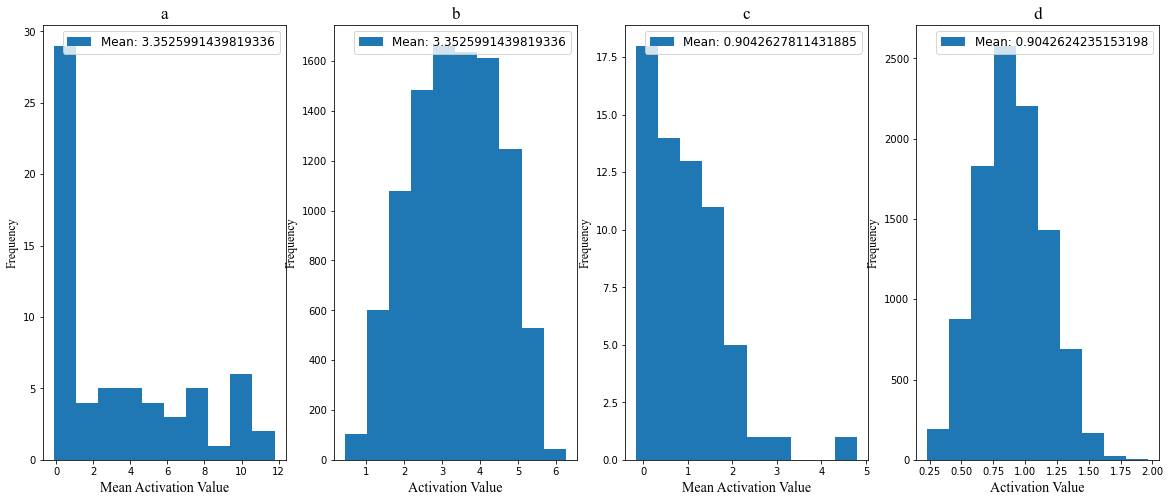

In [314]:
features_cnn = np.load('npy_objects/features_cnn.npy', allow_pickle=True)
features_optimum_dropout = np.load('npy_objects/features_optimum_dropout.npy', allow_pickle=True)

fig, axs = plt.subplots(1, 4, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].hist(np.mean(features_cnn, axis=0), label='Mean: {}'.format(np.mean(np.mean(features_cnn, axis=0))))
axs[0].set_xlabel('Mean Activation Value', fontname='Times New Roman', fontsize=14)
axs[0].set_ylabel('Frequency', fontname='Times New Roman', fontsize=12)
axs[0].legend()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[1].hist(np.mean(features_cnn, axis=1), label='Mean: {}'.format(np.mean(np.mean(features_cnn, axis=1))))
axs[1].set_xlabel('Activation Value', fontname='Times New Roman', fontsize=14)
axs[1].set_ylabel('Frequency', fontname='Times New Roman', fontsize=12)
axs[1].legend()
axs[2].set_title('c', fontname='Times New Roman', fontsize=17)
axs[2].hist(np.mean(features_optimum_dropout, axis=0), label='Mean: {}'.format(np.mean(np.mean(features_optimum_dropout, axis=0))))
axs[2].set_xlabel('Mean Activation Value', fontname='Times New Roman', fontsize=14)
axs[2].set_ylabel('Frequency', fontname='Times New Roman', fontsize=12)
axs[2].legend()
axs[3].set_title('d', fontname='Times New Roman', fontsize=17)
axs[3].hist(np.mean(features_optimum_dropout, axis=1), label='Mean: {}'.format(np.mean(np.mean(features_optimum_dropout, axis=1))))
axs[3].set_xlabel('Activation Value', fontname='Times New Roman', fontsize=14)
axs[3].set_ylabel('Frequency', fontname='Times New Roman', fontsize=12)
axs[3].legend()
plt.show()

**Figure 14**: a) Histogram of the mean activation value of the $64$ neurons of the fully connected layer for the CNN without dropout (averaged over the $10,000$ samples. b) Histogram of the activation value of the $10,000$ samples averaged over the $64$ neurons of the fully connected layer for the CNN model without dropout. c) Histogram of the mean activation value of the $64$ neurons of the fully connected layer for the CNN with dropout (averaged over the $10,000$ samples. d) Histogram of the activation value of the $10,000$ samples averaged over the $64$ neurons of the fully connected layer for the CNN model with dropout.

We can see from *Figure 14* a) and c) that the $64$ neurons of the fully-connected layer have a smaller mean for the CNN model with dropout compared to the one without, with $60/64$ neurons being in the range $[0,2]$, while for the CNN model without dropout that is true for only $33/64$ neurons. As a result of the sparsity in the weights, the neurons in the CNN model with dropout rely on a smaller number of inputs (fewer neurons) to learn features from, hence, the features that they learn are more robust, have better generalisability and are less noisy.

<a name="q123"></a>

#### Task 1.2.3 [^](#outline)

Next, we plot the results obtained from the MLP model in **Task 1.1.1** to those obtained from the CNN model with optimal dropout in **Task 1.2.2** to compare their accuracy, shown in *Figure 15*.

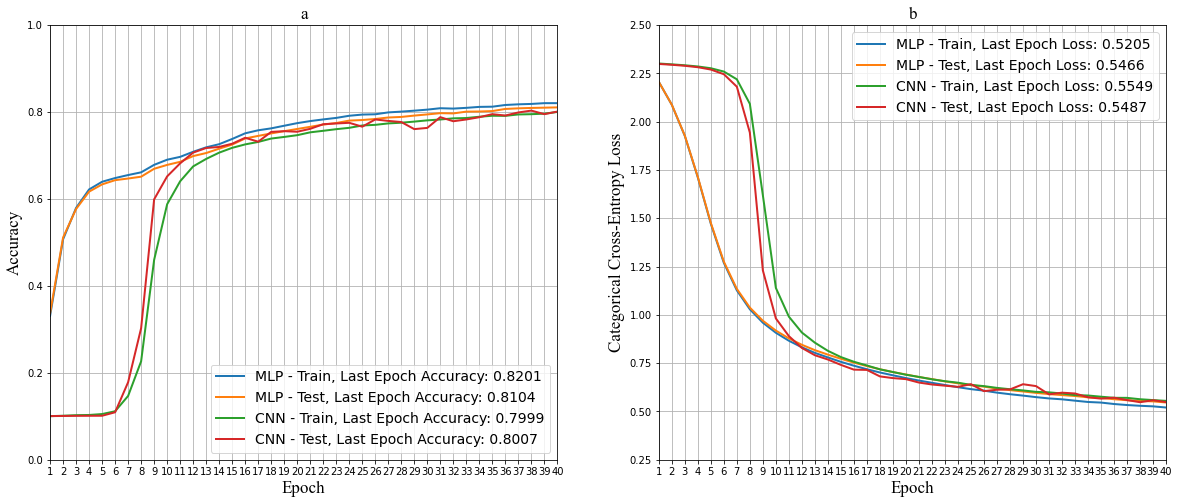

In [325]:
cnn_1_2_2_train_loss = np.load('npy_objects/cnn_1_2_2_train_loss.npy', allow_pickle=True)
cnn_1_2_2_train_acc = np.load('npy_objects/cnn_1_2_2_train_acc.npy', allow_pickle=True)
cnn_1_2_2_test_loss = np.load('npy_objects/cnn_1_2_2_test_loss.npy', allow_pickle=True)
cnn_1_2_2_test_acc = np.load('npy_objects/cnn_1_2_2_test_acc.npy', allow_pickle=True)
learning_rate = 1e-3
batch_size = 256
epochs = 40

epoch_accuracies = np.load('./npy_objects/epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_accuracies = np.load('npy_objects/test_epoch_accuracies_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
epoch_losses = np.load('npy_objects/epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)
test_epoch_losses = np.load('npy_objects/test_epoch_losses_'+str(epochs)+'_'+str(batch_size)+'_'+str(learning_rate)+'.npy', allow_pickle=True)


from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].plot(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)), epoch_accuracies, label='MLP - Train, Last Epoch Accuracy: {}'.format(round(epoch_accuracies[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(test_epoch_accuracies), len(test_epoch_accuracies)), test_epoch_accuracies, label='MLP - Test, Last Epoch Accuracy: {}'.format(round(test_epoch_accuracies[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)), cnn_1_2_2_train_acc, label='CNN - Train, Last Epoch Accuracy: {}'.format(round(cnn_1_2_2_train_acc[-1], 4)), linewidth=2)
axs[0].plot(np.linspace(1, len(cnn_1_2_2_train_acc), len(cnn_1_2_2_train_acc)), cnn_1_2_2_test_acc, label='CNN - Test, Last Epoch Accuracy: {}'.format(round(cnn_1_2_2_test_acc[-1], 4)), linewidth=2)
axs[0].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Accuracy', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(np.linspace(1, len(epoch_accuracies), len(epoch_accuracies)))
axs[0].set_xlim(1, len(cnn_1_2_2_train_acc))
axs[0].set_ylim(0, 1)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[1].plot(np.linspace(1, len(epoch_losses), len(epoch_losses)), epoch_losses, label='MLP - Train, Last Epoch Loss: {}'.format(round(epoch_losses[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(test_epoch_losses), len(test_epoch_losses)), test_epoch_losses, label='MLP - Test, Last Epoch Loss: {}'.format(round(test_epoch_losses[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(cnn_1_2_2_train_loss), len(cnn_1_2_2_train_loss)), cnn_1_2_2_train_loss, label='CNN - Train, Last Epoch Loss: {}'.format(round(cnn_1_2_2_train_loss[-1], 4)), linewidth=2)
axs[1].plot(np.linspace(1, len(cnn_1_2_2_test_loss), len(cnn_1_2_2_test_loss)), cnn_1_2_2_test_loss, label='CNN - Test, Last Epoch Loss: {}'.format(round(cnn_1_2_2_test_loss[-1], 4)), linewidth=2)
axs[1].set_xlabel('Epoch', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Categorical Cross-Entropy Loss', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(np.linspace(1, len(epoch_losses), len(epoch_losses)))
axs[1].set_xlim(1, len(cnn_1_2_2_train_loss))
axs[1].set_ylim(0.25, 2.5)
axs[1].legend()
axs[1].grid()
plt.show()

**Figure 15**: a) Acuracy of train and test data-sets as a function of the number epochs for MLP and CNN with optimal dropout models. b) Categorical cross-entropy loss function of train and test data-sets as a function of the number of epochs for MLP and CNN with optimal dropout models.

We see from *Figure 15* that the MLP model converges faster than the CNN model with optimal dropout. In addition, we notice that the MLP model slightly outperformed the CNN model with dropout, having a test accuracy that is $1$% higher and train accuracy that is $2$% higher - small differences. However, we note that the MLP model has $959,994$ parameters, while the CNN model has $107,266$ parameters, which is almost 9 times fewer parameters! Moreover, it took the MLP model 131 minutes to train while it took the CNN model with optimal dropout rate only 9.5 minutes (both tested on CPU run-time). The reason why the CNN is able to achieve the same accuracy as the MLP model with 1/9th of the parameters and in 1/14th of the time is mainly because CNNs have sparse interactions, in the sense that deeper layers of the CNN have larger receptive fields than shallower layers, while also, CNNs benefit from parameter sharing, as weights applied to a given input are also 'tied' to other weights. Moreover, when the information arrives at the fully-connected layers of the CNN they have much fewer inputs than the fully connected layers of the MLPs (only the first few convolutional layers are slow in learning the features).

<a name="q124"></a>

#### Task 1.2.4 [^](#outline)

Finally, we choose one image from the the-test set in order to visualise itself and a single feature map from each convolutional layer and the max pooling layer, shown below in *Figure 15*.

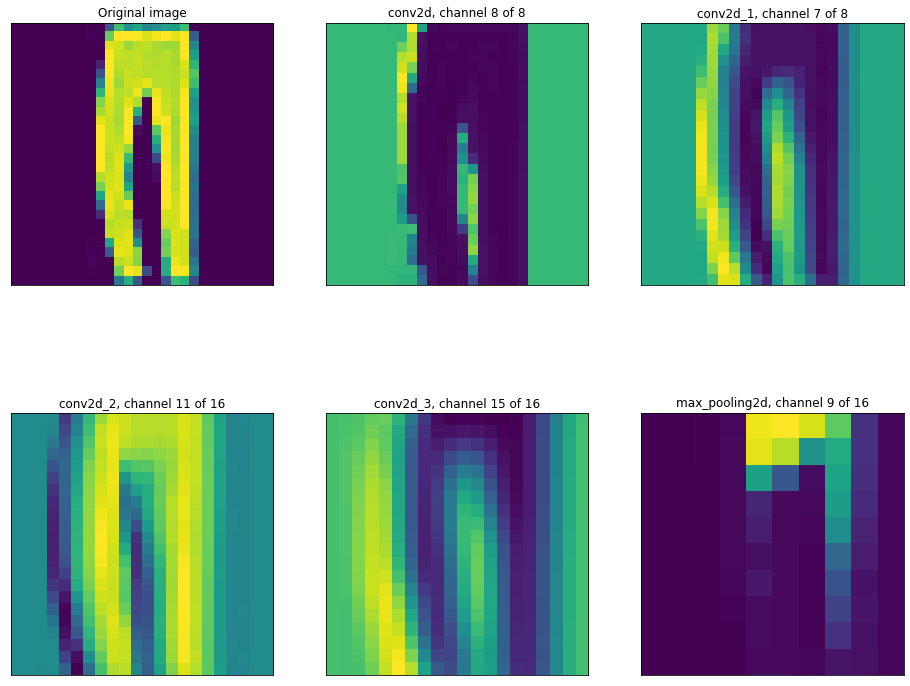

In [339]:
image = x_test[2][tf.newaxis,...]

from tensorflow.keras.models import Model

inputs = cnn.inputs  # obtain inputs from CNN model
layer_names = cnn_layer_names[:5]  # select the 4 convolutional layers and the max-pooling layer
outputs = [cnn.get_layer(layer_name).output for layer_name in layer_names]  # obtain the outputs of the above-mentioned layers (activations)
cnn_features = Model(inputs=inputs, outputs=outputs)  # obtain the CNN features for the specified inputs and outputs
features_cnn = cnn_features.predict(image)  # make a prediction using the CNN features selected on the test data

n_rows, n_cols = 2, 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 14))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

for i in range(len(features_cnn)+1):
    feature_map = features_cnn[i-1]
    num_channels = feature_map.shape[-1]
    row = i // n_cols
    col = i % n_cols
    if i == 0:
        axes[row, col].imshow(image[0])
        axes[row, col].set_title('Original image')
    else:
        random_feature = np.random.choice(num_channels)
        axes[row, col].imshow(feature_map[0, ..., random_feature])
        axes[row, col].set_title('{}, channel {} of {}'.format(layer_names[i-1], random_feature + 1, num_channels))
        
    axes[row, col].get_xaxis().set_visible(False)
    axes[row, col].get_yaxis().set_visible(False)
plt.show()

**Figure 16**: Visualisation of the 3rd image of the test-set and a single feature map from each convolutional layer and the max pooling layer.

We can see from *Figure 16* that the first few convolutional layers detect things like main shapes and edges, retaining the majority of the information present in the original image. Each next convolutional layer (deeper layer) begins to lose resemblance of the original image and learns features that are more abstract and less intuitive and clear; it is harder to interpret visually, as they begin to represent more the class of an image rather than the image itself. Moreover, the deeper the layer, the fewer features are detected; in essence, deeper layers become sparser, classifying features which do not appear in every part of an image.

<a name="task-2"></a>

# Task 2: Unsupervised Learning [^](#outline)

<a name="q21"></a>

## 2.1 Dimensionality Reduction and Clustering of a Subset of the Fashion-MNIST Image Data [^](#outline)

In this section we present dimensionality reduction, and in particular, Principal Component Analysis (PCA).

Diimensionality reduction refers to a process whereby data is transformed / reduced from a higher to a lower dimensionsal space, with the goal of retaining as much of the useful and meaningful information represented in the higher dimensional-space data as possible. Reducing the data to a lower dimensional space allows us to perform various tasks such as clustering with a lower computational cost, as well as to potentially get rid of features that may be highly unnecessary or redundant, e.g., highly correlated features.

One such example of dimensionality reduction is Principal Component Analysis (PCA), a spectral linear method. The main goal of PCA is to represent data in a lower dimensional space such that we have maximised variance of the data in the lower dimensional-space; thus offering maximised information. This is achieved by building the covariance matrix of data and choosing its eigenvectors (principal components) with the largest eigenvalues, representing most of the variance. Therefore, for some data-point $\mathbf{x}^{(i)}$ that could be written in terms of basis functions $\phi_j$:

$$\mathbf{x}^{(i)} = \sum_{j=1}^p \alpha_j^{(i)}\phi_j, \quad \text{such that} \: \phi_j \in \mathbb{R}^p.$$

Using PCA, we can write an approximation of this data-point as such:

$$\hat{\mathbf{x}}^{(i)}=\sum_{j=1}^m \left(\mathbf{x}^{{(i)^T}}\cdot\phi_j\right)\phi_j^*.$$

<a name="q211"></a>

#### Task 2.1.1 [^](#outline)

Initially, we normalise and centre the data in order for Singular Value Decomposition (SVD) to work properly, which is required to obtain the eigenvectors and eigenvalues of non-square matrices. We obtain the a set of $1,000$ images on which to perform PCA.

In [6]:
pca_images = x_train.copy()[:1000]  # Select the first N=1000 images to use for PCA

In [7]:
X = (pca_images.reshape(-1, 28 * 28)[:pca_images.shape[0]])  # Reshape the vector holding the images to be a vector of correct dimensions

In [8]:
# function to standardise images (normalises and centres the data)
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)  # subtracts mean and scales (normalises) by standard deviation
    return Xbar

In [9]:
X = standardise(X)  # standardise the data (normalise and centre)

Then we define a function to perform PCA reducing the original data matrix to some new reduced dimension $m$, obtaining the reduced data matrix `X_pca` as well as the first $m$ eigenvectors and eigenvalues of the data matrix, representing the largest explained variance, i.e., the largest eigenvalues and their corresponding eigenvectors.

In [10]:
from scipy.sparse import linalg

def pca_function(X, m):

    # create covariance matrix S
    C = 1.0/(len(X)-1) * np.dot(X.T, X)


    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, m, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

<a name="q212"></a>

#### Task 2.1.2 [^](#outline)

For this task we compute the top $m=25$ principal components using the function we defined above, obtaining the reduced data matrix as well as the top $m=25$ eigenvectors and eigenvalues.

In [11]:
m = 25  # Number of top Principal Components to consider

# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X, m)

We then print the shapes of the lower-dimensional space data to ensure that we have succesfully reduced it to $25$ principal components, as required.

In [390]:
print(X_pca.shape, eigenvectors.shape, eigenvalues.shape)

(1000, 25) (784, 25) (25,)


Having checked that we have obtained the correct data matrix, eigenvalues and eigenvectors we then plot the top $m=25$ principal components (eigenvalues) as well as their respective fraction of the explained variance as $m$ is increased, shown in *Figure 17*.

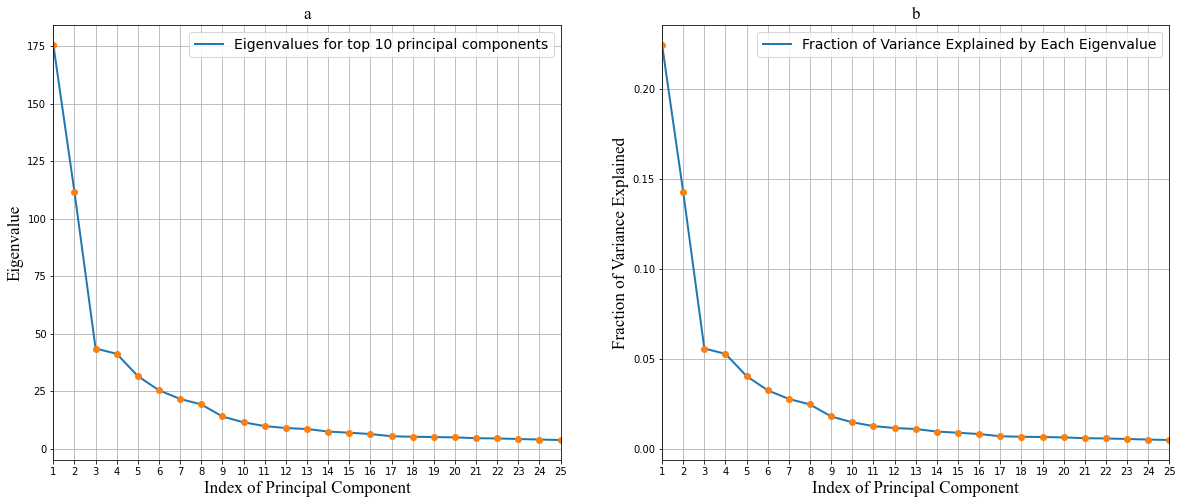

In [392]:
C = 1.0/(len(X)-1) * np.dot(X.T, X)  # Obtain the covariance matrix
all_eigenvalues, _ = np.linalg.eig(C)  # Obtain the eigenvalues of the covariance matrix
total_variance = abs(all_eigenvalues.sum())  # Get the total variance from summing all the eigenvalues of the covariance matrix

explained_variances = eigenvalues /  total_variance  # Obtain the explained variance by normalising each eigenvalue by the total variance
# print('The explained variance for the top {} principle components is: {}'.format(k, explained_variances))

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(1, 2, figsize=(20,8))
x_axis = np.linspace(1, 25, 25)
axs[0].set_title('a', fontname='Times New Roman', fontsize=17)
axs[0].plot(x_axis, eigenvalues, label='Eigenvalues for top {} principal components'.format(m), linewidth=2)
axs[0].plot(x_axis, eigenvalues, 'o')
axs[0].set_xlabel('Index of Principal Component', fontname='Times New Roman', fontsize=17)
axs[0].set_ylabel('Eigenvalue', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(x_axis)
axs[0].set_xlim(1, x_axis[-1])
# axs[0].set_ylim(0.25, 2.5)
axs[0].legend()
axs[0].grid()
axs[1].set_title('b', fontname='Times New Roman', fontsize=17)
axs[1].plot(x_axis, explained_variances, label='Fraction of Variance Explained by Each Eigenvalue', linewidth=2)
axs[1].plot(x_axis, explained_variances, 'o')
axs[1].set_xlabel('Index of Principal Component', fontname='Times New Roman', fontsize=17)
axs[1].set_ylabel('Fraction of Variance Explained', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(x_axis)
axs[1].set_xlim(1, x_axis[-1])
# axs[1].set_ylim(0, 1)
axs[1].legend()
axs[1].grid()
plt.show()

**Figure 17**: a) Top $m=25$ principal components (eigenvalues). b) Fraction of explained variance from the top $m=25$ principal components.

Looking at *Figure 17* we see that the optimal value for the reduced dimension is around $m=2$, as this is the smallest eigenvalue that still provides a significant fraction of the explained variance; eigenvalues from $3$ onward describe a small fraction of the decreased variance. The first two eigenvalues provide $22.5$% $14.5$% of the explained variance respectively ($37$% of the data in total), while the next few eigenvalues only describe about $3$ to $5$% of the explained variance.

<a name="q213"></a>

#### Task 2.1.3 [^](#outline)

Next, to look further into our reduced data we plot it in the PCA space that is spanned by the top $m=2$ components and colour each data-point according to the class that they belong to, as shown in *Figure 18*.

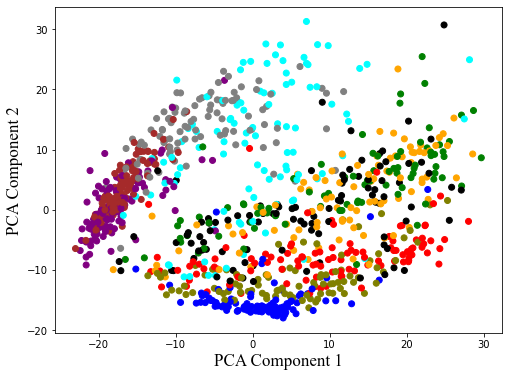

In [393]:
from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

classes = y_train.copy()[:1000]
colors = ['red', 'blue', 'green', 'olive', 'orange', 'purple', 'black', 'brown', 'cyan', 'gray']
class_colors = [colors[np.argmax(y)] for y in classes]

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=class_colors)  # Only using the 0th and 1st column of the data matrix
plt.xlabel('PCA Component 1', fontname='Times New Roman', fontsize=17)
plt.ylabel('PCA Component 2', fontname='Times New Roman', fontsize=17)
plt.show()

**Figure 18**: Data matrix reduced to $m=2$ dimensions plotted in the PCA space spanned by these $m=2$ principal components. Each different colour represents the class of each data-point.

From *Figure 18* we observe that the $10$ classes of images form clusters that are overlapping by a significant amount when reduced down to only the top $m=2$ principal components. As a result, we wouldn't expect a $k$-means clustering algorithm to be able to identify well the true number of classes for our data-set, which is $10$. *Figure 18* suggest that there is separation that can somewhat be distinguished for some classes, but the overlap is quite significant and visible to a large extent due to the spacing of the individual points on this graph.

<a name="q214"></a>

#### Task 2.1.4 [^](#outline)

Finally, we consider the data points as described by the top $m=2$ principal components of PCA and apply $k$-means to cluster the points. 

In clustering we basically want to find groups for our data so that the data-points that lie within a given group are more similar to each other in comparison to the data-points which lie outside of their group. In particular, using $k$-means clustering we assign each data-point to one of $k$ clusters by looking at the centroid closest to that data-point. Initially, the centroids are chosen at random, and we iteratively update them until the within-cluster dissimilarity does not improve. The within-cluster dissimilatiry is defined as:

$$W(C)=\frac{1}{2} \sum_{l=1}^k \frac{1}{|c_l|} \sum_{i, j \in c_l} ||\mathbf{x}^{(i)} - \mathbf{x}^{(j)}||^2,$$
for points $\mathbf{x}^{(i)}$ and $\mathbf{x}^{(j)}$ in cluster $c_l$.

We vary the parameter $k$ in the $k$-means algorithm between $2$ and $10$ and look for the optimal parameter $k$ as that which lies on the elbow of the graph of Within-Cluster Dissimilarlity as a function of $k$.

Firstly we reduce our data to the top $m=2$ principal components using PCA.

In [17]:
m_optimum = 2  # Define the optimum smallest number of top principal components to use from elbow of graph

# compute the projection, the eigenvector and eigenvalues from our function
X_pca_optimum, eigenvectors_optimum, eigenvalues_optimum = pca_function(X, m_optimum) 

n_samples, n_features = X_pca_optimum.shape

# number of clusters k
ks = np.linspace(2, 10, 9)

Next we define the $k$-means clustering algorithm in order to group our reduced data into $k$ clusters.

In [18]:
np.random.seed(123)

Ws = []
for k in ks:
    k = int(k)
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X_pca_optimum, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:n_features]
        
    max_iter = 40
    new_labels = np.zeros(len(X_pca_optimum))
    difference = 0

    w = []
    # k-means algorithm
    for i in range(max_iter):
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X_pca_optimum - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            for c in range(k):
                w.append(np.power(X_pca_optimum[labels==c] - centroids[c], 2).sum())
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X_pca_optimum[labels==c], axis=0)
    Ws.append(np.sum(w))
    print('k={}, W={}'.format(k, Ws[k-2]))

k=2, W=157929.67155006088
k=3, W=94158.81130041022
k=4, W=62804.371258329
k=5, W=49722.59676159811
k=6, W=41433.569234361654
k=7, W=36620.28528474317
k=8, W=29027.501359941554
k=9, W=26130.86146576558
k=10, W=23438.03971181856


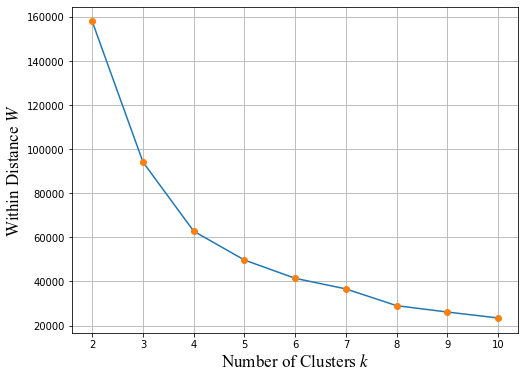

In [19]:
from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

plt.figure(figsize=(8,6))
plt.plot(ks, Ws)
plt.plot(ks, Ws, 'o')
plt.xlabel('Number of Clusters ' + r'$k$', fontname='Times New Roman', fontsize=17)
plt.ylabel('Within Distance ' + r'$W$', fontname='Times New Roman', fontsize=17)
plt.grid()
plt.show()

**Figure 19**: Within-cluster dissimilarity as a function of the number of clusters $k$ in the $k$-means clustering algorithm.

In order to find the optimal value of $k$ we want to look at the *'elbow'* of the curve in *Figure 19* and want to find the value of $k$ so that increasing it further will not reduce the within-cluster dissimilarity by any signiciant amount; the smalled value of $k$ that results in a small value of $W$. Looking at *Figure 19* we see that the optimal value of $k$ is around $4$, as increasing $k$ further doesn't result in any significant improvement in the clustering. There is no clear *'elbow'* in this case, so we choose the optimal value of $k$ where the ambiguity is observed. Therefore, the optimal $k$ value is not equal to the true number of classes $10$.

Reducing the data to only the top $m=2$ principal components, which only represent about $37$% of the explained variance and thus only about $37$% of the feature space, only a limited amount of information is available to describe the data and hence the clusters. Therefore, it is relatively difficult for the $k$-means clustering algorithm to be able to correctly identify all $10$ clusters, as the data is not very detailed in just $2$ dimensions.

<a name="q22"></a>

## 2.2 Clustering of the Feature Matrix [^](#outline)

In this section we employ a different kind of clustering known as ***hierarchical clustering***. One of the main differences with $k$-means clustering is that it does not assumes a number of clusters *a priori* but aims to provide a global description of the data and its intrinsic organisation. With hierarchical structuring the entire data is depicted with a binary tree called a ***dendrogram***. Every time the tree bifurcates, it essentially represents the merging of two groups of data-points.

In this particular case we will use an agglomerative scheme (bottom-up approach) for hierarchical clustering using ***group average*** or ***average linkage*** as our criterion for merging, given by:

$$d_{GA}(G, H)=\frac{1}{N_G N_H} \sum_{i \in G, j \in H} D_{ij}.$$

<a name="q221"></a>

#### Task 2.2.1 [^](#outline)

For this task we will use a new dataset comprising the interactions and social behaviour of bottlenose dolphins. Initially we import and inspect the dimensions of our data.

In [399]:
import pandas as pd

# Load the files: dolphin names, adjancy matrix, and feature matrix
dolphin_names = pd.read_csv('./CW2DATA/dolphin_names.csv').to_numpy()
adjacency_matrix = np.load('./CW2DATA/dolphins_A_62x62.npy', allow_pickle=True)
feature_matrix = np.load('./CW2DATA/dolphins_F_62x32.npy', allow_pickle=True)
print('Shape of dolphin names: ', dolphin_names.shape)  # Names of dolphins
print('Shape of adjacency matrix: ', adjacency_matrix.shape) # Adjacency matrix (NxN)
print('Shape of feature matrix: ', feature_matrix.shape)  # Feature matrix (Nxp) --> set of of p=32 features for each dolphin
print('Data-type of dolphin_names[:,0]: ', type(dolphin_names[0][0]))
print('Data-type of dolphin_names[:,1]: ', type(dolphin_names[0][1]))

Shape of dolphin names:  (62, 2)
Shape of adjacency matrix:  (62, 62)
Shape of feature matrix:  (62, 32)
Data-type of dolphin_names[:,0]:  <class 'int'>
Data-type of dolphin_names[:,1]:  <class 'str'>


We notice that our data contains $62$ dolphins indexed by integer and given a name each with $32$ features, whose social network is represented as a graph using an adjacency matrix of dimensions $62$ by $62$.

Now that we have loaded our data we need to define a distance metric. We will use Euclidean distances between points to get pair-wise distances as shown below.

In [21]:
def pairwise_distances(points):
    '''
    Args:
        points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
    Returns:
        A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
    '''
    N, D = points.shape
    distance = np.empty((N, N))
    
    # distance matrix will be symmetric, so avoid redundant computations.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            # Obtain the Euclidean distance between points
            d = np.sqrt(np.power(points[i, :] - points[j, :], 2).sum())
            distance[i, j] = d
            distance[j, i] = d
            
    return distance

In [22]:
d = pairwise_distances(feature_matrix)  # Obtain the distance between features of all nodes

Next, we define our average-linkage function to determine the mergers of clusters.

In [23]:
def average_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the average linkage value between two clusters.
    Args:
      distances: A numpy array of pair-wise distances for the given points.
      cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
      i: the first cluster id.
      j: the second cluster id.
    Returns:
      The average distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the average
    return pairs_distance.mean()

Next we define the hierarchical clustering algorithm which begins with all data-points as unique clusters and mergers two clusters at a time with each iterations. At the end it returns the clustering assignment at each level.

In [24]:
def hierarchical_clustering(points, distances, linkage):
    """
    The hierarchical clustering algorithm start with every point as a single cluster and 
    each iteration merges two clusters into one. We may wish to store all the 
    intermediate clustering results with respect to the number of clusters left.

    Args:
     points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
     distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
     linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Returns:
     A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
     The first row, i.e. a[0, :], represents the highest level of clustering where all columns have the same index value.
     The second row, i.e. a[1, :], represents all the points assigned into two cluster indices.
     The last row, i.e. a[N - 1, :], represents the points assigned into N - 1 cluster indices.
    """ 
    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # Begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    # The id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # Begin from level (N - 1) to level 1
    for level in range(N - 1, 0, -1):
        # if (level % 10) == 0:
            # print(f'level:{level}')
        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1) 
        
        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):
                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]
                d = linkage(distances, current_assignment, cluster_i, cluster_j)
                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)
                    
        
        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id
        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment
        
    return assignments

Then, we run our hierarchical clustering algorithm with the feature matrix of our dolphins data to obtain the clustering assignments at each level and use Scipy's `Scipy.Cluster.Hierarchy` package to plot the dendrogram we obtain using **average linkage**.

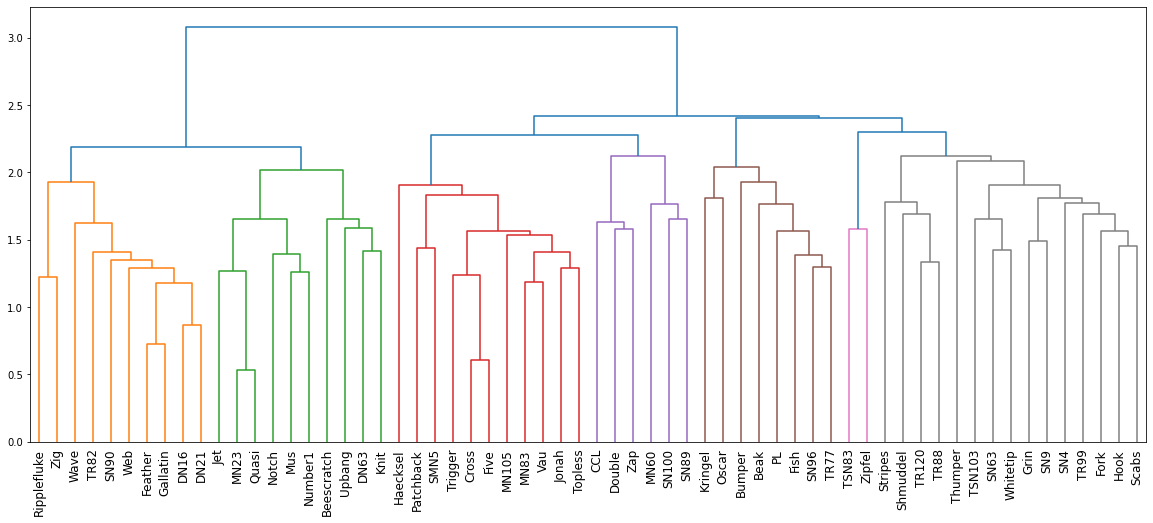

In [363]:
assignments = hierarchical_clustering(feature_matrix, d, average_linkage)

from scipy.cluster import hierarchy

fig, ax = plt.subplots(1, figsize=(20,8))
Z = hierarchy.linkage(feature_matrix, method='average')
# plt.figure(figsize=(20,8))
dn = hierarchy.dendrogram(Z)
nums = [int(item.get_text()) for item in ax.get_xticklabels()]
d_labels = [dolphin_names[n,1] for n in nums]
ax.set_xticklabels(d_labels, rotation=90, fontsize=12)
plt.show()

**Figure 20**: Dendrogram produced using the feature matrix of the social network of dolphins.

*Figure 20* demonstrates the dendrogram representing the hierarchical clustering of the network of dolphins.

<a name="q222"></a>

#### Task 2.2.2 [^](#outline)

In order to assess the quality of a given clustering we will define a quality measure called the ***Silhouette Score*** which is obtained by computing the mean intra-cluster and mean nearest-cluster distances for each sample and taking the average. We first define the Silhouette score for one sample as such:

$$\text{Silhouette Coefficient} = \frac{d_2-d_1}{\text{max}(d_1, d_2)},$$
where $d_1$ is the mean intra-cluster distnace and $d_2$ is the mean nearest-cluster distance. The Silhouette score is then obtained by averaging the Silhouette score over all samples.

The two methods bellow have been coded to obtain the per-sample Silhouette coefficient and the Silhouette score by averaging the Silhouette Coefficient over all samples.

In [33]:
def silhouette_coefficient(feature_matrix, assignments, level, sample_index):
    """
    This function calculates the silhouette coefficient for a specific sample for a given level, from 
    a specific feature matrix with given assignments, using the equation:
        silhouette_coeff = (d_2 - d_1)/max(d_2 - d_1),
            where: d_1 is the average distance between the sample and the points in its cluster,
                   d_2 is the average distance between the sample and the points in the nearest cluster
    Args:
        feature_matrix: Nxp matrix containing the features (p) of all N samples
        assignments: NxN matrix storing the clustering assignment at each level
        level: int, the index of the level from the assignments
        sample_index: int, the index of the sample from the feature matrix
    Returns:
        silhouette_coeff: float, the silhouette coefficient
    """
    
    sample_value = assignments[level][sample_index]  # Get the assignment ID of the given sample

    # Gets the indices of samples that belong to the same cluster (by looking at those with the same ID in the assignment matrix at that level)
    sample_cluster_indices = [i for i in range(len(assignments[level])) if assignments[level][i] == sample_value and i!= sample_index]  # Excludes itself to avoid duplicate calculations
    # Gets the features of the sample that belong to the same cluster, using the indices obtained above
    sample_cluster_features = [feature_matrix[idx] for idx in sample_cluster_indices]
    
    if len(sample_cluster_indices) == 0:  # if the cluster is empty (i.e., it only contains the sample itself), return 0
        d1 = 0
    else:
        # Calculate the mean distance between the sample and all points in its cluster
        d1 = np.mean([np.sqrt((feature_matrix[sample_index]-sample_cluster_features[i])**2) for i in range(len(sample_cluster_features))])
    
    # Get the IDs of all other clusters by looking at the set of IDs in the assignment for the given level
    other_clusters = list(set(np.unique(assignments[level])) - {sample_value})
    # Obtain the indices of sample that belong to each other cluster, using same method as above
    other_clusters_indices = [[i for i in range(len(assignments[level])) if assignments[level][i] == el and i!= sample_index] for el in other_clusters] # Excludes itself to avoid duplicate calculations
    # Gets the features of the sample that belong to the other clusters, using the indices obtained above
    other_clusters_features = [[feature_matrix[idx] for idx in other_cluster_indices] for other_cluster_indices in other_clusters_indices]

    # Calculate the mean distance between the sample and all points in the nearest cluster (hence the min. function)
    d2 = min([np.mean([np.sqrt((feature_matrix[sample_index]-other_cluster_features[i])**2) for i in range(len(other_cluster_features))]) for other_cluster_features in other_clusters_features])

    if d1 == 0:
        silhouette_coeff = 0  # If d1 is 0 set the silhouette coefficient to 0
    else:
        silhouette_coeff = (d2-d1)/max(d1, d2)  # Return silhouette coefficient using equation mentioned above
    
    return silhouette_coeff

In [31]:
def silhouette_score(feature_matrix, assignments):
    """
    This function calculates the silhouette score for each lebel by averaging the silhouette coefficient for all samples in a given layer.

    Args:
        feature_matrix: Nxp matrix containing the features (p) of all N samples
        assignments: NxN matrix storing the clustering assignment at each level
    Returns:
        silhouette_scores: list, the silhouette score calculated for all levels
    """
    
    silhouette_scores = []  # Will hold the silhouette score for each level
    for i in range(2, len(assignments)-1):  # Disregards the first 2 and the last layer
        total = 0
        for j in range(len(feature_matrix)):
            silhouette_coeff = silhouette_coefficient(feature_matrix, assignments, i, j)  # Obtain silhouette coefficient for each sample at each level
            total += silhouette_coeff
        silhouette_scores.append(total/len(feature_matrix))  # Calculate the silhoutte score as the mean from all samples in a given level
    return silhouette_scores

We then obtain the Silhouette score using our feature matrix and assignments from our dendrogram and plot the Silhouette score as a function of the level of hierarchical clustering, shown in *Figure 21*.

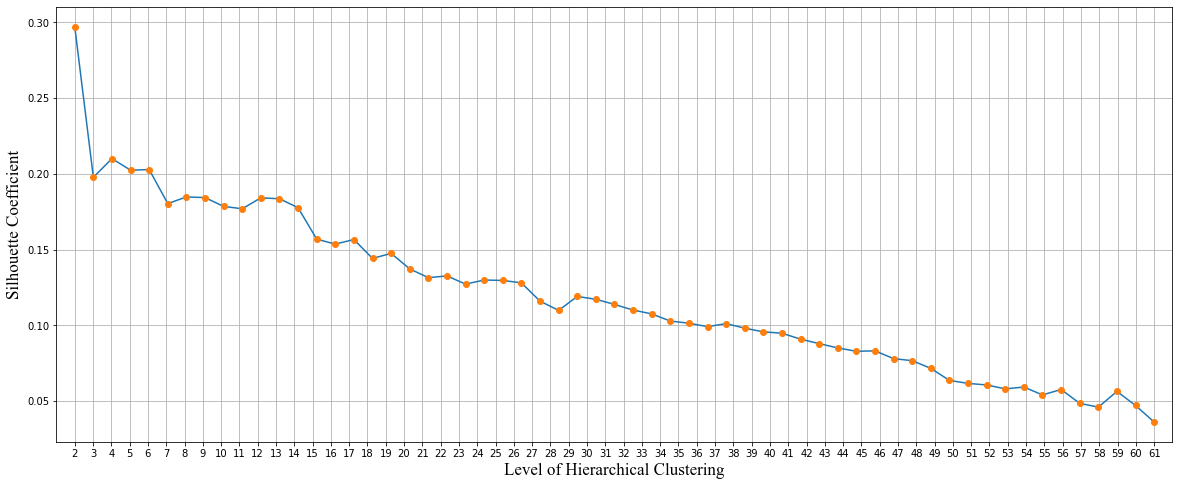

Optimal Silhouette Score at level 2


In [34]:
silhouette_scores = silhouette_score(feature_matrix, assignments)  # Obtain the silhouette scores for all samples at all levels

from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

plt.figure(figsize=(20, 8))
plt.plot(np.linspace(2, len(assignments)-1, len(assignments)-3), silhouette_scores)
plt.plot(np.linspace(2, len(assignments)-1, len(assignments)-3), silhouette_scores, 'o')
plt.xlabel('Level of Hierarchical Clustering', fontname='Times New Roman', fontsize=17)
plt.ylabel('Silhouette Coefficient', fontname='Times New Roman', fontsize=17)
plt.xticks(np.linspace(2, len(assignments)-1, len(assignments)-2, dtype=int))
plt.xlim(1, 62)
plt.grid()
plt.show()

print('Optimal Silhouette Score at level {}'.format(int(np.linspace(2, len(assignments)-1, len(assignments)-3)[np.argmax(silhouette_scores)])))

**Figure 21**: Silhouette score as a function of the level of hierarchical clustering for the dendrogram of the social network of dolphins.

The optimal level of hierarchical clustering the maximises the Silhouette score is $2$.

<a name="q23"></a>

## 2.3 Graph-Based Analysis [^](#outline)

In this task we explore the social network of the dolphins studied by marine biologists in New Zealand in 2003. For this case, we want to be able to represent a social network which we will do with a graph. In particular, we represent the graph of 'frequent associations' of dolphins and we encode that using an adjacency matrix $A_{N\times N}$, so that:

$$A_{ij} = \begin{cases}1, \quad \text{if nodes  } i \text{  and  } j \text{  are connected} \\0, \quad \text{otherwise}\end{cases}$$

We can use this matrix to represent our social network and calculate various useful properties.

<a name="q231"></a>

#### Task 2.3.1 [^](#outline)

One of the things we want to calculate includes the combinatorial Laplacian of our graph and the symmetric normalised Laplacian. The Laplacian for our graph is given by:

$$\boldsymbol{L}=\boldsymbol{D}\boldsymbol{A},$$

where $\boldsymbol{A}$ is our adjacency matrix and $\boldsymbol{D}$ is the diagonal matrix of node degrees, which is obtained by summing over the rows of the adjacency matrix and setting it to a diagonal matrix. In addition, the symmetric normalised Laplacian is obtained as follows:

$$\boldsymbol{L} = \boldsymbol{I} - \boldsymbol{D}^{-1/2} \boldsymbol{A}\boldsymbol{D}^{-1/2}$$

This symmetric normalised Laplacian is useful in performing partitionings of a graph, such as spectral partitioning. When partitioning a graph we often define a cost function, which is often associated to the number of edges that would have to be cut in order to split a graph into $k$ sub-graphs. In the case of spectral partitioning the cost function is determined as:

$$C= \frac{1}{2} \sum_{i \in S_1, j \in S_2} A_{ij},$$

whose minimum $C^*$ is given by:

$$C^*=\lambda_2 \frac{n_1 n_2}{N},$$
where $\lambda_2$ is the eigenvalue of the first non-trivial eigenvector of the Laplacian we calculated above. 

Initially we want load the necessay packages to visualise networks, and visualise our adjacency matrix using a heatmap, shown in *Figure 22*, where purple (or 0) represents no connections, and yellow (or 1) represents connections between two dolphins.

In [35]:
import networkx as nx
from matplotlib.colors import ListedColormap

from scipy.spatial.distance import cdist
from scipy.sparse import linalg

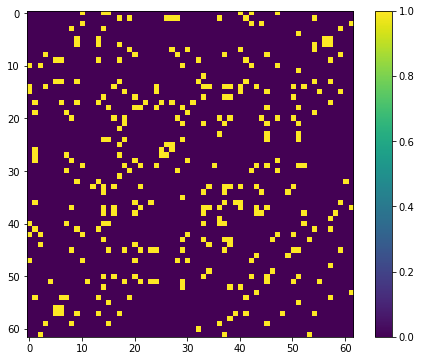

In [400]:
plt.figure(figsize=(8, 6))
plt.imshow(adjacency_matrix)
plt.colorbar();

**Figure 22**: Heatmap of the adjacency matrix of the social network of dolphins. Purple represents no connections (0) and yellow represents connections between nodes (1).

Next, we want to visualise the network of dolphins using the NetworkX package.

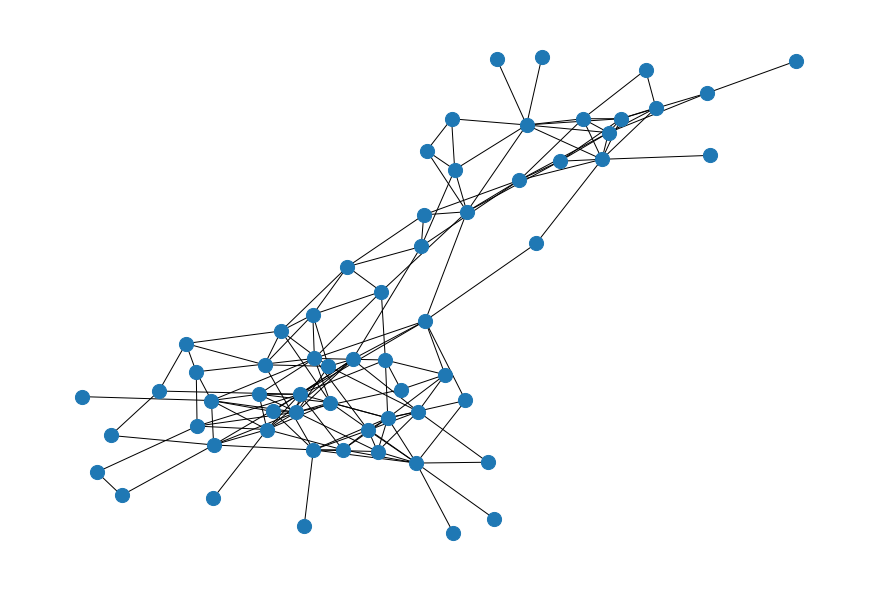

In [233]:
# constructing a networkx graph object
g = nx.Graph(adjacency_matrix)

# drawing networkx graph
plt.figure(figsize=(12,8))
# positions = nx.spring_layout(g)
nx.draw(g, positions, node_size=200)

**Figure 23**: Network representation of the social network of dolphins, where every node represents a dolphin and edges represent associations between dolphins.

We then obtain our diagonal matrix $\boldsymbol{D},$ the combinatorial Laplacian $\boldsymbol{L},$ and the normalised Laplacian of the dolphin network, following the equations mentioned above.

In [55]:
# define diagonal matrix of node degrees
weighted_degree = adjacency_matrix.sum(axis=1) 

# create diagonal matrix of degree
D = np.diag(weighted_degree)

In [56]:
# define Laplacian
L = D-adjacency_matrix

# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# define the normalised Laplacian
L_norm = np.eye(adjacency_matrix.shape[0]) - D_inv_sqrt.dot(adjacency_matrix.dot(D_inv_sqrt))

Once the normalised Laplacian of the dolphin network is calculated, we obtain the two smallest eigenvalues and their corresponding eigenvectors.

In [57]:
# return the smallest magnitude eigenvectors and eigenvalues
eigenvals, eigenvecs = linalg.eigsh(L_norm, 2, which="SM", return_eigenvectors=True)

In [58]:
# printing the eigenvalues
print('The first eigenalue is: {}'.format(eigenvals[0]))
print('The second eigenalue is: {}'.format(eigenvals[1]))
print('The first eigenvector is: {}'.format(eigenvecs[0]))
print('The second eigenvector is: {}'.format(eigenvecs[1]))

The first eigenalue is: 6.235198121918567e-17
The second eigenalue is: 0.03952455375743451
The first eigenvector is: [-0.13736056  0.07851822]
The second eigenvector is: [-0.15861032 -0.16036544]


The first and smallest eigenvalue is $\lambda_1=0$ as expected as the first eigenvector $\boldsymbol{v}_1=\boldsymbol{1}$ cannot be a solution, and the second smallest is $\lambda_2=0.03952$ (the smallest non-zero eigenvalue also known as the *algebraic connectivity*), which is the one that is used to calculate the minimum cost function as shown at the beginning of **Task 2.3**. This eigenvalue corresponds to the eigenvector where the nodes of the graph can be split into two groups which are defined by their sign. The algebraic connectivity is relatively small such that we should expect it to be able to result in a good bipartition of the graph.

Then we set all negative values to 0 and all the positive values to 1, such that we can visualise the 2 distinct classes of our spectral clustering, shown below in *Figure 24*.

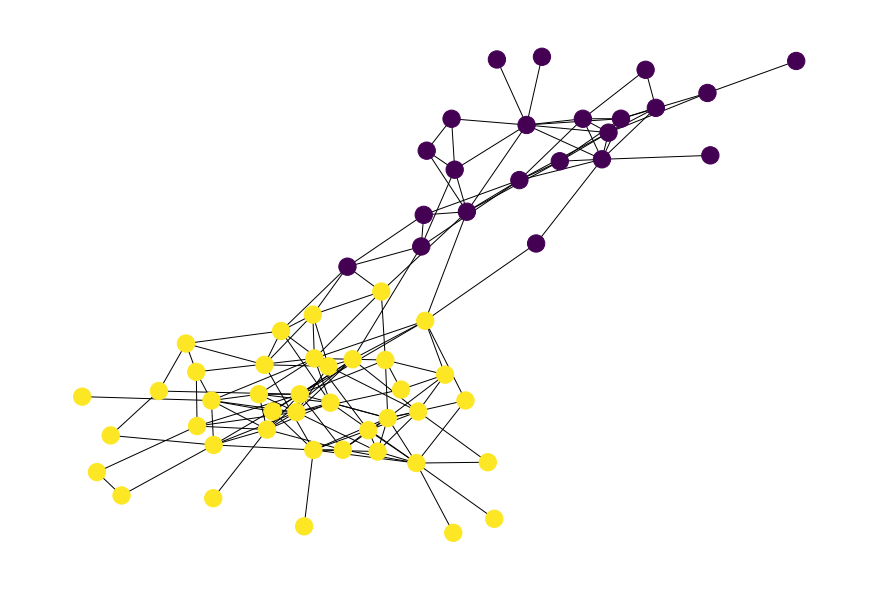

In [467]:
# extract the second eigenvector
second_eigenvector = eigenvecs[:,1]

spectral_partition = second_eigenvector
spectral_partition[spectral_partition<0] = 0  # set all negative values to 0 for spectral partitioning
spectral_partition[spectral_partition>0] = 1  # set all positive values to 1 for spectral partitioning

plt.figure(figsize=(12,8))
# draw the network structure coloured by the second eigenvector
nx.draw(g, positions, node_color=spectral_partition)

**Figure 24**: Spectral partition of the social network of dolphins using the algebraic connectivity (or spectral gap) corresponding to the second eigenvector where nodes are split into two groups defined by their sign (yellow if they are negative and purple if they are positive).

<a name="q232"></a>

#### Task 2.3.2 [^](#outline)

In this section we explore the concept of graph centralities, a measure of the importance of nodes or edges in a graph. There are various ways in which we can define the importance of a node in a graph, but in this case we will consider 3 types of centralities:

1. PageRank
2. Degree Centrality
3. Eigenvector Centrality

The simplest type of centrality is degree centrality, whereby a node is as important as its degree number, $\boldsymbol{c}_d = \frac{\boldsymbol{d}}{2E}$. Next, eigenvector centrality determines a node's centrality by the centrality of the nodes it is connected to, and is given by $\boldsymbol{c}_e(i) = \alpha \sum_j A_{ij}\boldsymbol{c}_e(j)$ for some constant $\alpha$, where the component of the leading eigenvector from the adjacent matrix gives the centrality of each node. Finally, PageRank is determined iteratively as: $\boldsymbol{c}_{PR \:t+1}=\alpha(AD^{-1})\boldsymbol{c}_{PR \:t}+(1-\alpha)\frac{1}{N}\boldsymbol{1},$ where $\boldsymbol{c}_{PR \:0}$ is initialised as a vector of 1s.

Below we measure the PageRank, Degree, and Eigenvector centrality for the dolphin social network, plotting the graphs of the networks according to these centralities in *Figures 25, 26, 27*.

#### PageRank Centrality

In [466]:
def PageRank(alpha=0.85):
    page_rank_centrality = np.ones((adjacency_matrix.shape[0], 1))

    for i in range(2000):  # iterate a large number of times, so that convergence is achieved
        previous_value = page_rank_centrality
        # use the iterative equation ofo PageRank in order to obtain the PageRank centrality
        page_rank_centrality = alpha * (adjacency_matrix @ np.linalg.inv(D)) @ page_rank_centrality + (1-alpha)*(1/adjacency_matrix.shape[0]) * np.ones((adjacency_matrix.shape[0], 1))
    
    return page_rank_centrality

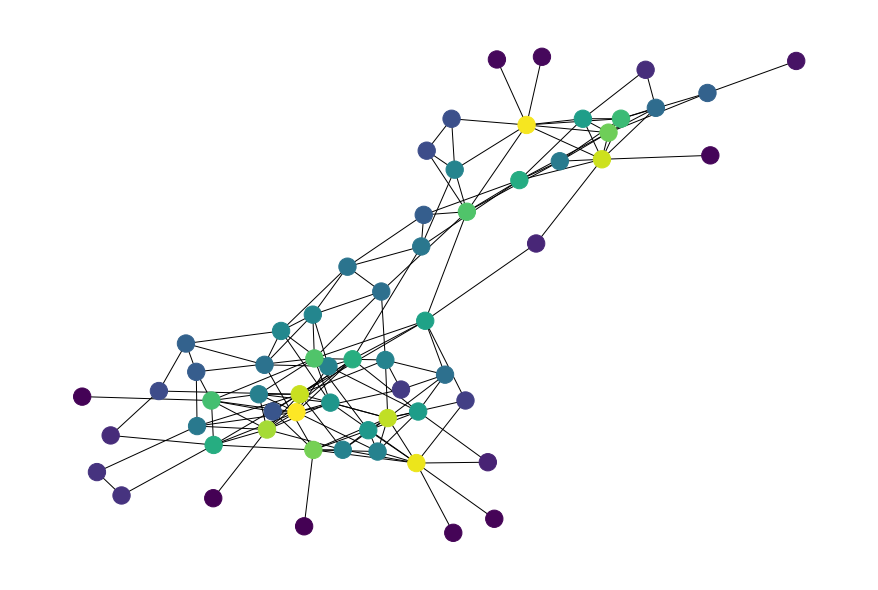

In [403]:
page_rank_centrality = PageRank(alpha=0.85)
plt.figure(figsize=(12,8))
# draw the eigenvector centrality
nx.draw(g, positions, node_color=page_rank_centrality)

**Figure 25**: Social network of dolphins with PageRank Centrality applied

#### Degree Centrality

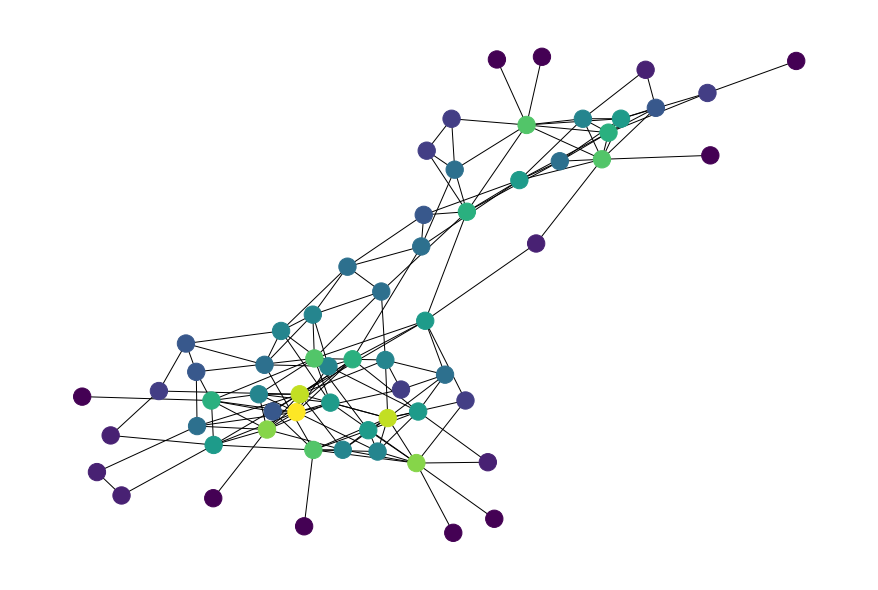

In [405]:
degree_centrality = adjacency_matrix.sum(axis=1)

plt.figure(figsize=(12,8))
# draw the degree distribution
nx.draw(g, positions, node_color=degree_centrality)

**Figure 26**: Social network of dolphins with Degree Centrality applied

#### Eigenvector Centrality

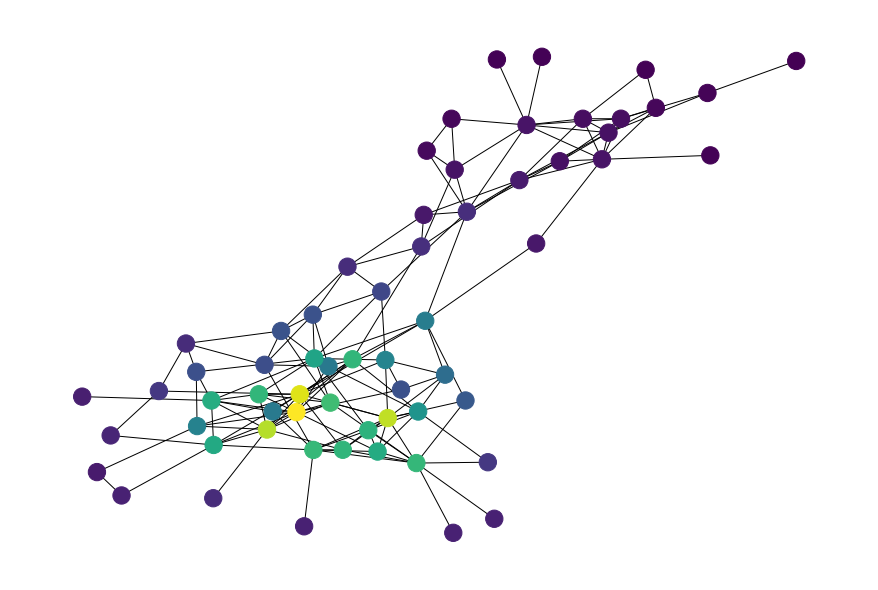

In [406]:
# compute the eigenvector associated with the largest eigenvalue
eigenvalue_centrality, eigenvector_centrality = linalg.eigsh(adjacency_matrix, 1, which="LM", return_eigenvectors=True)

plt.figure(figsize=(12,8))
# draw the eigenvector centrality
nx.draw(g, positions, node_color=eigenvector_centrality)

**Figure 27**: Social network of dolphins with Eigenvector Centrality applied

Next, we report the different kinds of centralities side-by-side in a table below and plot the centralities in scatter plots to visualise them in *Figure 28*.

In [453]:
import seaborn as sns
pd.set_option('display.max_rows', 75)
features = ['Dolphin Names', 'PageRank Centrality', 'Degree Centrality', 'Eigenvector Centrality']
centralities_pd = pd.DataFrame(np.array([dolphin_names[:,1], page_rank_centrality.flatten(), degree_centrality.flatten(), eigenvector_centrality.flatten()]).T, columns=features)
print(centralities_pd)

   Dolphin Names PageRank Centrality Degree Centrality Eigenvector Centrality
0           Beak           0.0169654                 6               0.128504
1     Beescratch           0.0246507                 8              0.0420761
2         Bumper           0.0133381                 4              0.0397571
3            CCL          0.00962906                 3              0.0793348
4          Cross           0.0050798                 1              0.0292874
5           DN16            0.014428                 4             0.00655926
6           DN21           0.0200536                 6              0.0121913
7           DN63            0.015643                 5               0.042901
8         Double           0.0170983                 6               0.143102
9        Feather           0.0234585                 7              0.0121974
10          Fish           0.0151084                 5              0.0752535
11          Five           0.0050798                 1          

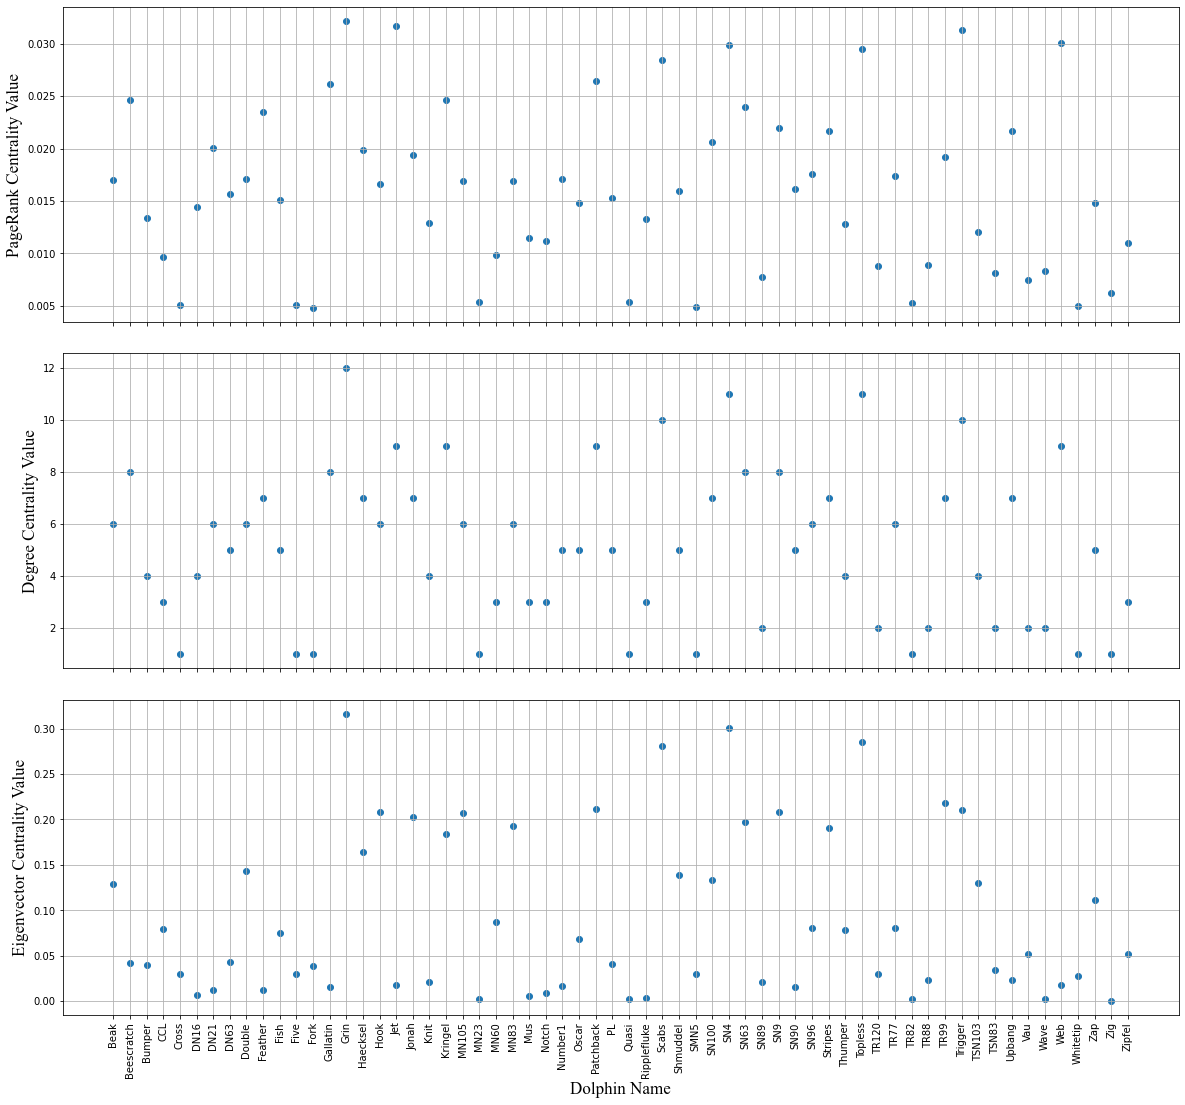

In [454]:
from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

fig, axs = plt.subplots(3, 1, figsize=(20,20), sharex=True)
axs[0].scatter(np.linspace(1, 62, 62), page_rank_centrality.flatten())
axs[0].set_ylabel('PageRank Centrality Value', fontname='Times New Roman', fontsize=17)
axs[0].set_xticks(np.linspace(1, 62, 62))
axs[0].set_xticklabels(dolphin_names[:,1], rotation=90)
axs[0].grid()
axs[1].scatter(np.linspace(1, 62, 62), degree_centrality.flatten())
axs[1].set_ylabel('Degree Centrality Value', fontname='Times New Roman', fontsize=17)
axs[1].set_xticks(np.linspace(1, 62, 62))
axs[1].set_xticklabels(dolphin_names[:,1], rotation=90)
axs[1].grid()
axs[2].scatter(np.linspace(1, 62, 62), eigenvector_centrality.flatten())
axs[2].set_xlabel('Dolphin Name', fontname='Times New Roman', fontsize=17)
axs[2].set_ylabel('Eigenvector Centrality Value', fontname='Times New Roman', fontsize=17)
axs[2].set_xticks(np.linspace(1, 62, 62))
axs[2].set_xticklabels(dolphin_names[:,1], rotation=90)
axs[2].grid()
plt.subplots_adjust(bottom=0.2, top=0.9, hspace=0.1)
plt.show()

**Figure 28**: Scatter plots of the 3 different kinds of centralities: PageRank Centrality (top), Degree Centrality (middle), Eigenvalue Centrality (Bottom) for each dolphin denoted by name.

We can see from the scatter plots which nodes (dolphins) are highly central according to the three centralities, however, to make things simpled we simply print the 5 most central dolphins by each type of centrality.

In [465]:
# obtain the 5 nodes (dolphins) that have the highest PageRank centrality
top_5_page_rank_centrality = page_rank_centrality.flatten().argsort()[-5:][::-1]
print('5 Most Central Dolphins By Page Rank Centrality: ')
for i in top_5_page_rank_centrality:
    print('  ', dolphin_names[i, 1])

# obtain the 5 nodes (dolphins) that have the highest Degree centrality
top_5_degree_centrality = degree_centrality.argsort()[-5:][::-1]
print('5 Most Central Dolphins By Degree Centrality: ')
for i in top_5_degree_centrality:
    print('  ', dolphin_names[i, 1])

# obtain the 5 nodes (dolphins) that have the highest Eigenvector centrality
top_5_eigenvector_centrality = eigenvector_centrality.flatten().argsort()[-5:][::-1]
print('5 Most Central Dolphins By Eigenvector Centrality: ')
for i in top_5_eigenvector_centrality:
    print('  ', dolphin_names[i, 1])

5 Most Central Dolphins By Page Rank Centrality: 
   Grin
   Jet
   Trigger
   Web
   SN4
5 Most Central Dolphins By Degree Centrality: 
   Grin
   Topless
   SN4
   Scabs
   Trigger
5 Most Central Dolphins By Eigenvector Centrality: 
   Grin
   SN4
   Topless
   Scabs
   TR99


It seems that dolphin indexed $14$ named *Grin* is the most central according to all types of centralities, while dolphins indexed $45$ and $37$ named *Topless* and *SN4* share the 2nd and 3rd most central positions according to Degree Centrality and Eigenvector Centrality, while dolphin *SN4* also appears in the PageRank Centrality list. Finally, dolphin indexed $51$ named *Trigger* appears in the 5 most central dolphins according to 2 kinds of centralities; PageRank and Degree centrality, making it a highly central node (dolphin) too.

Next, in order to look at the correlations between the different kinds of centralities we obtain the Pearson product-moment correlation coefficients for all centralities and plot that in a heatmap shown in *Figure 29*, and we also plot a pair-plot (scatter-plot) of the 3 centralities shown in *Figure 30*.

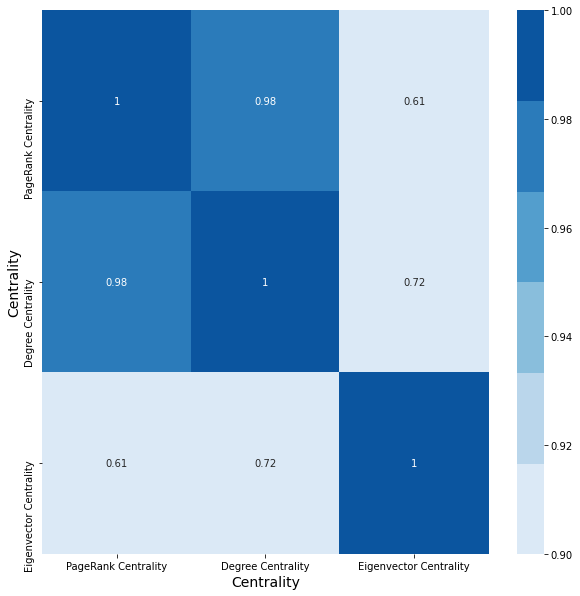

In [456]:
heatmap_1 = np.corrcoef([page_rank_centrality.flatten(), degree_centrality, eigenvector_centrality.flatten()])

import seaborn as sns
x_axis_labels = features[1:]
y_axis_labels = features[1:]
fig, ax = plt.subplots(figsize=(10, 10))
color = sns.color_palette("Blues")
s = sns.heatmap(heatmap_1, xticklabels=x_axis_labels, yticklabels=y_axis_labels, ax=ax, cmap=color, vmin=0.9, vmax=1, annot=heatmap_1)
s.set_xlabel('Centrality', fontsize=14)
s.set_ylabel('Centrality', fontsize=14)
plt.show()

**Figure 29**: Heatmap representin the Perason product-moment coefficients for the 3 different kinds of centralities for the social network of dolphins.

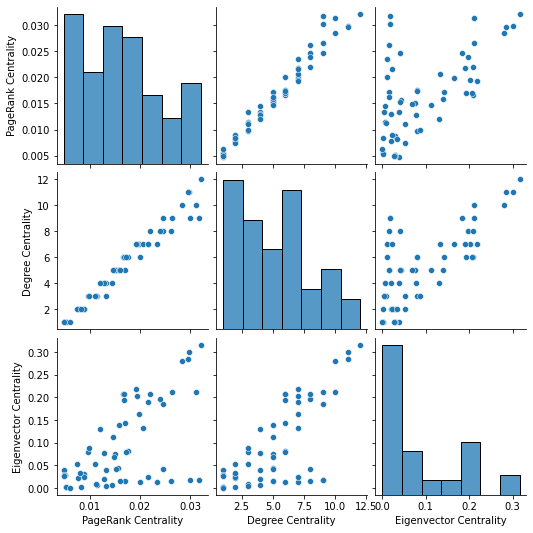

In [459]:
import seaborn as sns
sns.pairplot(centralities_pd[1:], kind='scatter')
plt.show()

**Figure 30**: Scatter-plot (pair-plot) of the 3 different kinds of centralities, demonstrating the distribution of each on the diagonals, and their correlations on the off-diagonal plots.

We can see from *Figure 29* that PageRank and Degree Centrality are very highly correlated (more than Eigenvalue Centrality is with either of them) with a Pearson product-moment score of $0.98$, while Degree centrality is also relatively highly correlated with Eigenvalue Centrality with a Pearson product-moment score of $0.72$. PageRank is also correlated with Eigenvalue Centrality with a Pearson product-moment score of $0.62$, however, not as strongly as with Degree Centrality. It seems that Degree Centrality is most similar with the other two centralities, as it shares most central dolphins with both other types of centralities.

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

<a name="q31"></a>

## 3.1 Non-Negative Matrix Factorization (NMF) for Dimensionality Reduction [^](#outline)

Similar to the way we performed dimensionality reduction with PCA in **Task 2.1** in this Task we will be performing dimensionality reduction using a slightly different technique, called Non-Negative Matrix Factorisation (NMF). The main idea of NMF is for all the variables to be restricted to be positive (non-negative). This is particularly applicable to images, made out of pixels which are grayscale values. As a result, negative values would not make sense. In NMF the data matrix $X$ (N by M) is approximated:

$$\mathbf{X} \approx \mathbf{W}\mathbf{H},$$
so that $W{ij} \geq 0, H_{ij} \geq 0$, where $\mathbf{H}$ has the equivalent of non-negative principal components, while $\mathbf{W}$ (N by k) has the non-negative coefficients representing some data-point in the basis vectors of $\mathbf{H}$ (k by M). Their product $\mathbf{W}\mathbf{H}$ gives an approximation to $\mathbf{A}$.

In order for the factorisation to work correctly the matrix must be positive, hence we normalise it to be between $0$ and $1$. We use the following multiplicative rules:

$$\mathbf{H}_{[i,j]}^{n+1}\leftarrow \mathbf{H}_{[i,j]}^{n} \frac{(( \mathbf{W}^n)^T \mathbf{X})_{[i,j]}}{((\mathbf{W}^n)^T \mathbf{W}^n \mathbf{H}^n)_{[i,j]}}$$

$$\mathbf{W}_{[i,j]}^{n+1}\leftarrow \mathbf{W}_{[i,j]}^{n} \frac{(\mathbf{X}(\mathbf{H}^{n+1})^T)_{[i,j]}}{(\mathbf{W}^n \mathbf{H}^{n+1} (\mathbf{H}^{n+1})^T)_{[i,j]}}$$

and once they both have reached stability, we stop.

<a name="q311"></a>

#### Task 3.1.1 [^](#outline)

In this case we will apply NMF to the same images we used for PCA in **Task 2.1**.

In [89]:
nmf_images = x_train.copy()[:1000]
nmf_images = nmf_images.reshape(nmf_images.shape[0], nmf_images.shape[1]**2)

In [460]:
def normalize_nmf(X):
    X_norm = (X- np.min(X) + 1e-12) / (np.max(X) - np.min(X))
    return X_norm

Then, we normalise the data so that we can perform non-negative matrix factorisation.

In [461]:
nmf_images = normalize_nmf(nmf_images)

In [462]:
# choosing the number of dimensions on which to project
m=10

# setting the random seed (just so everyone gets the same results...)
np.random.seed(0)

# m x k components matrix, usually interpreted as the coefficients, where m is the number of data
W = np.random.rand(nmf_images.shape[0], m)

# k x n matrix interpreted as the basis set, where n is the number of features (e.g. pixels)
H = np.random.rand(m, nmf_images.shape[1])

We define as our cost function the $\chi^2$.

In [382]:
# lets define a cost matrix to compare the difference
def cost(X, W, H):
  
    # compute the difference between X and the dot product of W and H
    diff = X - np.dot(W, H)

    chi2 = ((X*diff) * diff).sum() / (X.shape[0]*X.shape[1])
    
    return chi2

We then perform dimensionality reduction using NMF reducing the data to $m=10$ dimensions for $500$ iterations.

In [463]:
# set the number of iterations
n_iters = 500

# empty list for chi2 
chi2 = []

# loop over the n iterations
for i in range(n_iters):
    # compute the update on H
    H = H * ((W.T.dot(nmf_images)) / W.T.dot(W.dot(H)))

    # compute the update on W
    W = W * ((nmf_images.dot(H.T)) / (W.dot(H.dot(H.T))))

    # compute the chi2 and append to list
    chi2.append(cost(nmf_images, W, H))

We then plot the convergence of the NMF algorithm as a function of the number of iterations in the algorithm.

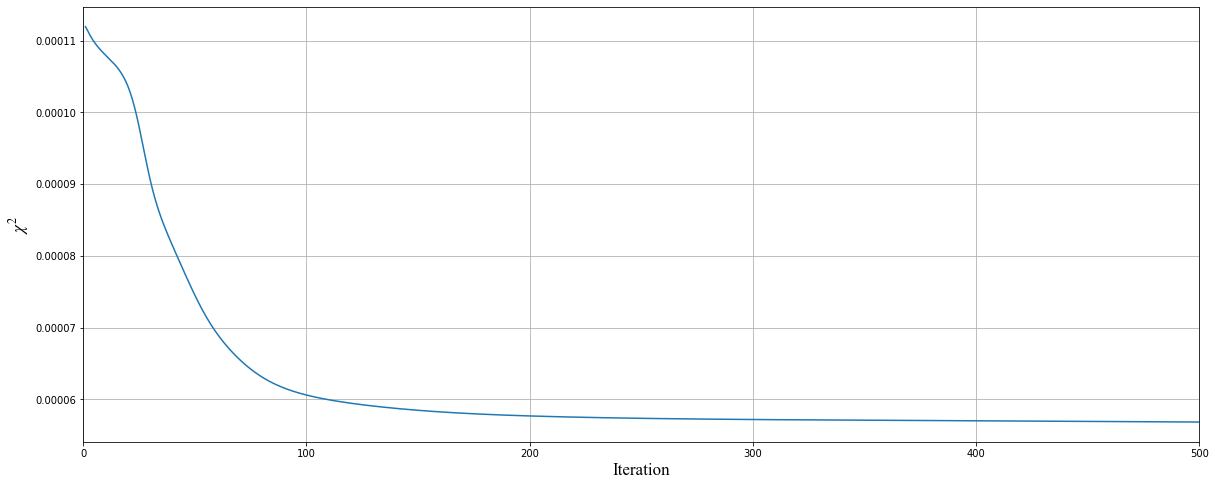

In [464]:
from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

plt.figure(figsize=(20, 8))
plt.plot(np.linspace(1, n_iters, n_iters), chi2)
plt.xlabel('Iteration', fontname='Times New Roman', fontsize=17)
plt.ylabel(r'$\chi^2$', fontname='Times New Roman', fontsize=17)
plt.xlim(0, n_iters)
plt.grid()
plt.show()

**Figure 31**: Cost function ($\chi^2$) as a function of iteration for NMF.

<a name="q312"></a>

#### Task 3.1.2 [^](#outline)

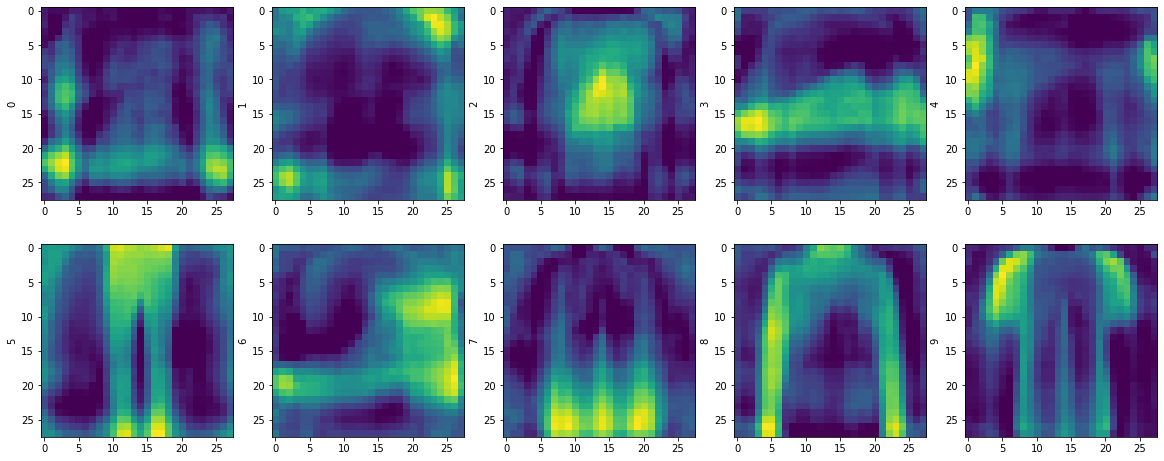

In [387]:
from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(2, 5, figsize=(20,8))
for i, ax in enumerate(axs.reshape(-1)):
    ax.imshow((H[i,:]).reshape(-1, 28))
    ax.set_ylabel(str(i))
plt.show()

**Figure 32**:

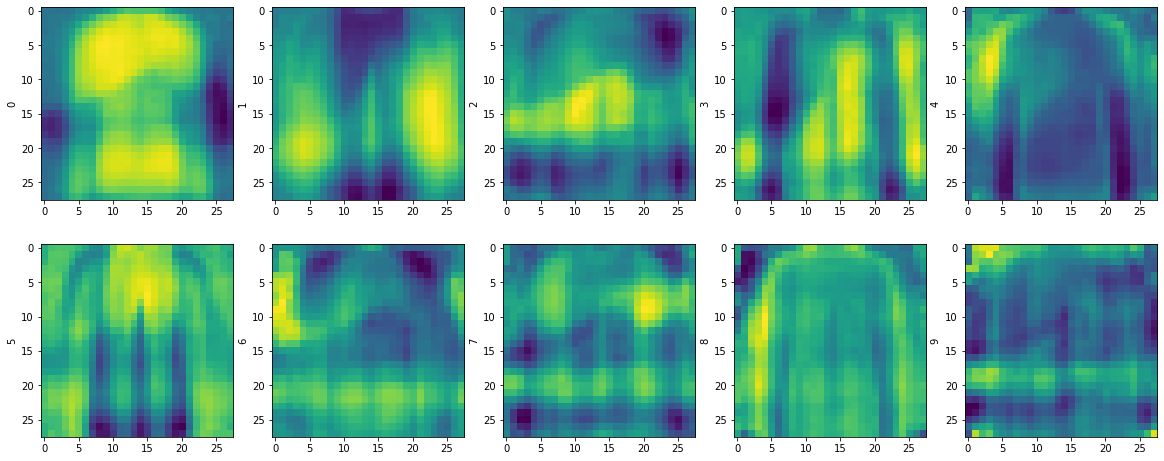

In [111]:
from matplotlib.ticker import FormatStrFormatter
params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
fig, axs = plt.subplots(2, 5, figsize=(20,8))
for i, ax in enumerate(axs.reshape(-1)): 
    ax.imshow(eigenvectors[:,i].reshape([28,28]))
    ax.set_ylabel(str(i))
plt.show()

**Figure 33**:

<a name="q32"></a>

## 3.2 Community Detection [^](#outline)

<a name="q331"></a>

#### Task 3.2.1 [^](#outline)

For this task we use the **Louvain algorithm** provided by the NetworkX package, in order to maximise modularity and find the optimal community structure for the dolphin graph, algorithm taken from NetworkX, available at: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.louvain.louvain_communities.html#networkx.algorithms.community.louvain.louvain_communities

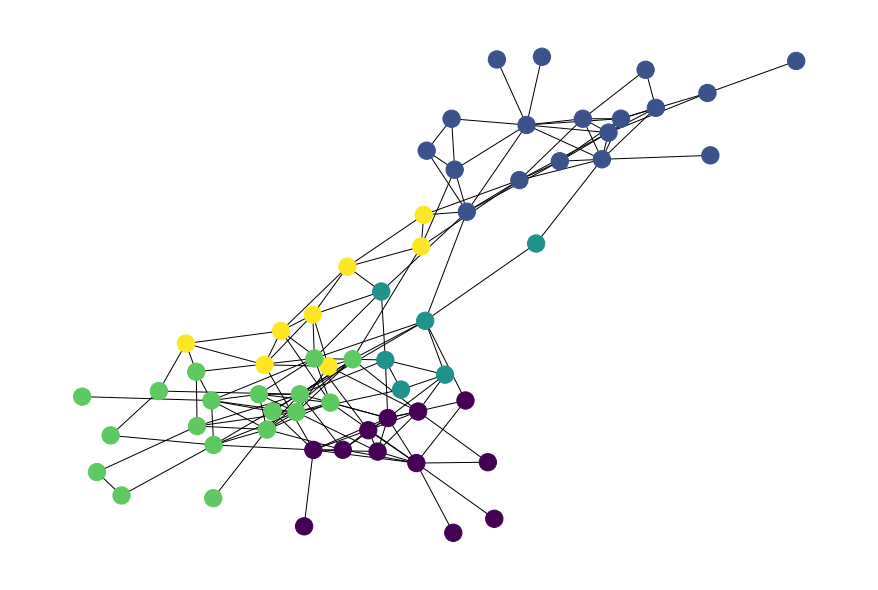

In [232]:
import networkx.algorithms.community as nx_comm

list_of_optimal_clusters = nx_comm.louvain_communities(g, seed=123)
dolphin_indices = [list(list_of_optimal_clusters[i])[j] for i in range(len(list_of_optimal_clusters)) for j in range(len(list_of_optimal_clusters[i]))]

colors = {0:10, 1:20, 2:30, 3:40, 4:50}

dolphin_colors = []
for i in range(len(list_of_optimal_clusters)):
    for j in range(len(list_of_optimal_clusters[i])):
        dolphin_colors.append(colors[i])

dolphin_indices, dolphin_colors = zip(*sorted(zip(dolphin_indices, dolphin_colors)))

plt.figure(figsize=(12,8))
# draw the eigenvector centrality
nx.draw(g, positions, node_color=dolphin_colors)

**Figure 34**: Graph of social network of dolphins using the Louvain algorithm to find the optimal community structure for the dolphin graph. 5 different colours represent 5 clusters in the social network.

<a name="q322"></a>

#### Task 3.2.2 [^](#outline)

Finally, we use the Adjusted Rand Index (ARI)

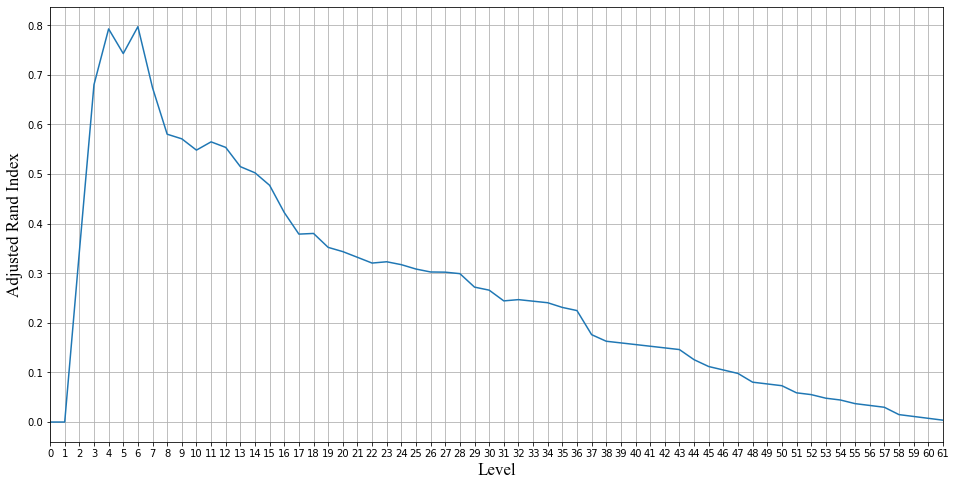

In [255]:
import sklearn

ari_scores = [sklearn.metrics.adjusted_rand_score(assignments[i], dolphin_colors) for i in range(len(assignments))]

params = {'legend.fontsize': 14}
plt.rcParams.update(params)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['mathtext.fontset'] = 'stix'

plt.figure(figsize=(16, 8))
plt.plot(ari_scores)
plt.xlabel('Level', fontname='Times New Roman', fontsize=17)
plt.ylabel('Adjusted Rand Index', fontname='Times New Roman', fontsize=17)
plt.xlim(0, len(assignments)-1)
plt.xticks(np.linspace(0, len(assignments)-1, len(assignments), dtype=int))
plt.grid()
plt.show()

**Figure 35**: